In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from pathlib import Path

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\danie\AppData\Local\Temp\ipykernel_7588\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [4]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.teamgamelogs import TeamGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats
from nba_api.stats.endpoints.leaguedashteamptshot import LeagueDashTeamPtShot

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.leaguehustlestatsteam import LeagueHustleStatsTeam
from nba_api.stats.endpoints.leaguedashteamstats import LeagueDashTeamStats
from nba_api.stats.endpoints.teamgamelogs import TeamGameLogs

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter


import matplotlib.ticker as mtick

In [6]:
plt.style.use('fivethirtyeight')


zoom = 0.45
team_root_dir = '../../team_logos_id/'
player_root_dir = 'player_imgs/'

def get_player_img(player_id, zoom=zoom):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id, zoom):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [7]:
game_logs = PlayerGameLogs(season_nullable='2023-24').get_data_frames()[0]

In [8]:
player_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season='2023-24').get_data_frames()[0]

In [9]:
player_stats.loc[:, 'TSA'] = player_stats.FGA + 0.44 * player_stats.FTA

In [10]:
player_stats = player_stats.loc[(player_stats.GP >= 7) & (player_stats.MIN >= 20)]

In [11]:
top_shooters = player_stats.sort_values(by='FG3A', ascending=False).iloc[:50]

In [13]:
top_shooters = player_stats.sort_values(by='TSA', ascending=False).iloc[:50]

In [14]:
top_shooters.FG3_PCT = top_shooters.FG3_PCT * 100

In [15]:
top_shooters.loc[:, 'TS_PCT'] = top_shooters.PTS / (2 * (top_shooters.FGA + 0.44 * top_shooters.FTA)) * 100

In [25]:
game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

In [16]:
def smooth_value(values, i, f1, f2, f3):
    value = values[i] * f2
    value_prev = 0
    if i >= 0:
        value_prev = values[i-1] * f1
    value_next = 0
    if i <= len(values)-2:
        value_next = values[i+1] * f3
    return value_prev + value + value_next

In [26]:
variances = []
ts_variances = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    player_game_logs = game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME]
    player_game_logs = player_game_logs.loc[player_game_logs.FG3A > 0]
    variances.append(player_game_logs.FG3_PCT.var())
    ts_variances.append(player_game_logs.TS_PCT.var())

In [27]:
top_shooters.loc[:, 'FG3_PCT_VARIANCE'] = variances

In [29]:
deviations = []
ts_deviations = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    player_game_logs = game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME]
    player_game_logs = player_game_logs.loc[player_game_logs.FG3A > 0]
    deviations.append(player_game_logs.FG3_PCT.std())
    ts_deviations.append(player_game_logs.TS_PCT.std())
    
top_shooters.loc[:, 'FG3_PCT_DEVIATION'] = deviations

In [30]:
top_shooters.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
top_shooters.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

In [191]:
min(top_shooters.FG3_PCT.tolist())

22.6

In [193]:
diff = int(max(top_shooters.FG3_PCT.tolist())) - int(min(top_shooters.FG3_PCT.tolist()))
ticks = []
min_val = int(min(top_shooters.FG3_PCT.tolist()))
max_val = int(max(top_shooters.FG3_PCT.tolist()))
for i in range(min_val, max_val, 5):
    ticks.append(i)
if max_val not in ticks:
    ticks.append(max_val)

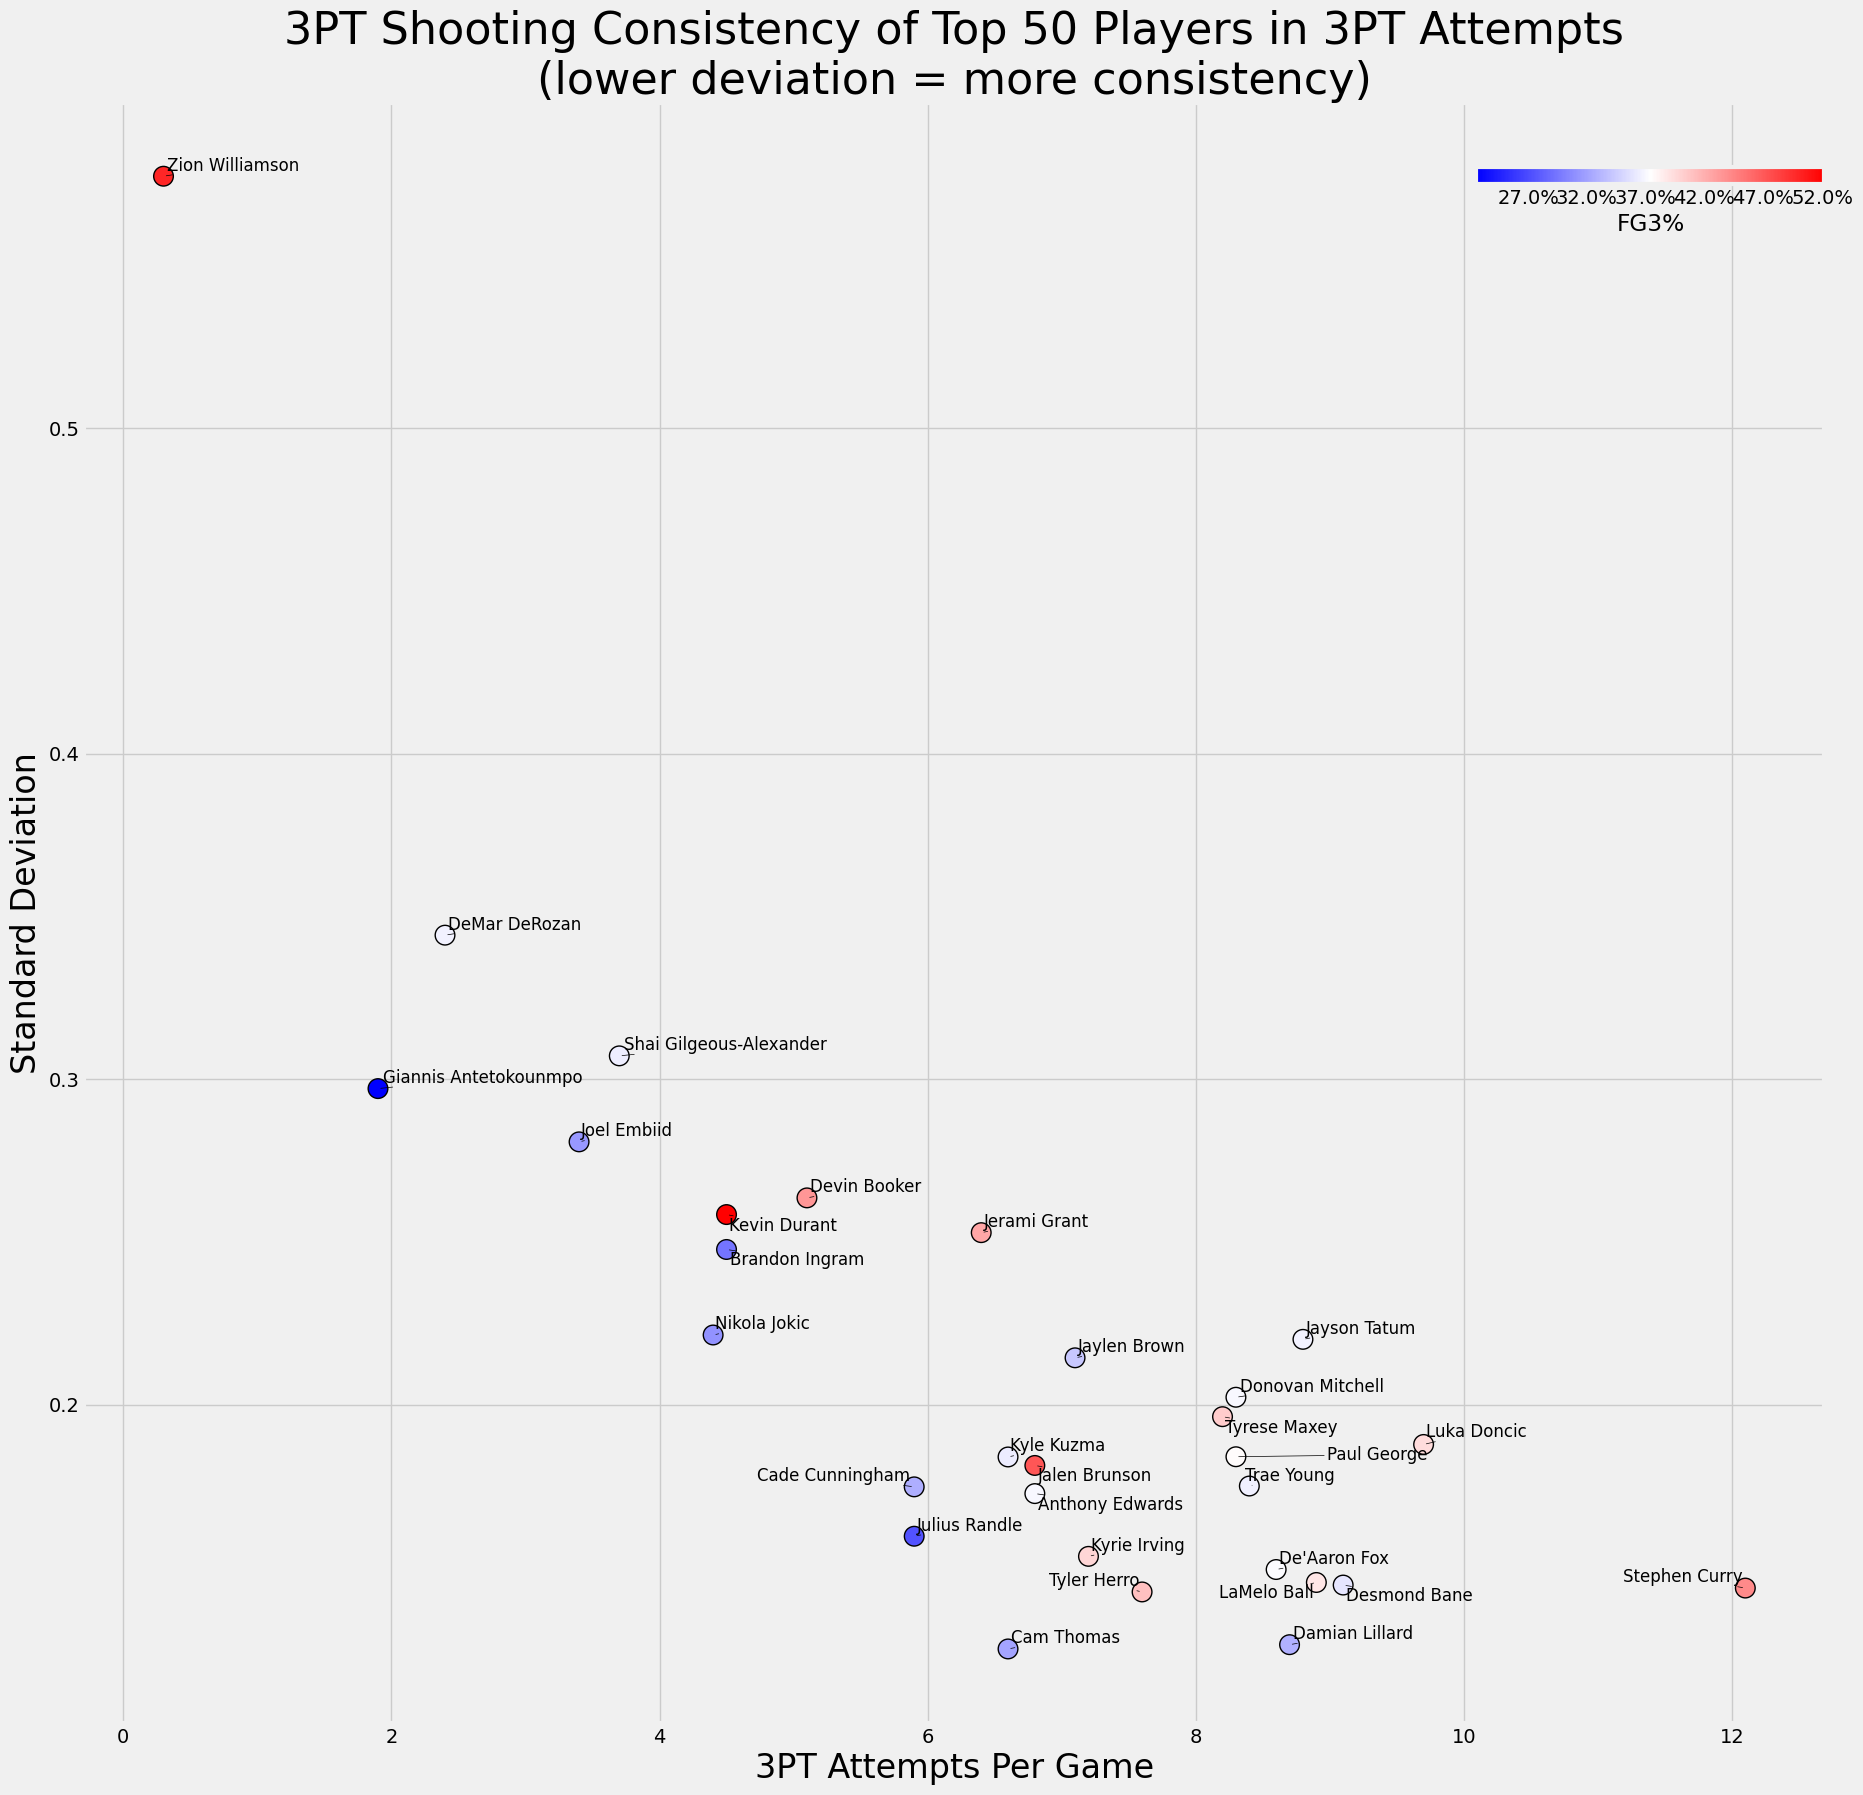

In [194]:
fig, ax = plt.subplots(figsize=(20, 20))

plot = ax.scatter(x=top_shooters.FG3A, y=top_shooters.FG3_PCT_DEVIATION, c=top_shooters.FG3_PCT, s=200, edgecolors='black', lw=1, cmap='bwr')
#ax.yaxis.set_major_formatter()
texts = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    texts.append(ax.text(x=item.FG3A, y=item.FG3_PCT_DEVIATION, s=item.PLAYER_NAME, size=12))
    #ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.FG3_PCT, item.FG3_PCT_VARIANCE), frameon=False)
    #ax.add_artist(ab)

ax.set_xlabel("3PT Attempts Per Game", size=24)
ax.set_ylabel("Standard Deviation", size=24)

adjust_text(texts, expand_objects=(1.5, 1.5), arrowprops={'arrowstyle': '-', 'color': 'black', 'lw': 0.5})

ax.set_title("3PT Shooting Consistency of Top 50 Players in 3PT Attempts\n(lower deviation = more consistency)", size=32)
fig.colorbar(plot, format=mtick.PercentFormatter(), label="FG3%", cax=ax.inset_axes((0.8, 0.95, 0.2, 0.01)), ticks=ticks, orientation='horizontal')

## 1D Convolution

In [161]:
top_shooters.PLAYER_NAME.unique()

array(['Stephen Curry', 'Luka Doncic', 'Desmond Bane', 'LaMelo Ball',
       'Tim Hardaway Jr.', 'Jayson Tatum', 'Damian Lillard',
       "De'Aaron Fox", 'Lauri Markkanen', 'Trae Young', 'Fred VanVleet',
       'Tyrese Haliburton', 'Donovan Mitchell', 'Paul George',
       'Tyrese Maxey', 'Bogdan Bogdanovic', 'Michael Porter Jr.',
       'Max Strus', 'Tyler Herro', 'Jordan Hawkins', 'Buddy Hield',
       'Klay Thompson', 'Zach LaVine', 'Kyrie Irving', 'Keegan Murray',
       'Jaylen Brown', 'Eric Gordon', 'Duncan Robinson', 'Kevin Huerter',
       'Anthony Edwards', 'Jalen Brunson', 'Coby White', 'Jordan Poole',
       'Kyle Kuzma', 'Cam Thomas', 'OG Anunoby', 'Cameron Johnson',
       'Jerami Grant', 'Spencer Dinwiddie', 'Devin Vassell', 'Sam Hauser',
       'Mikal Bridges', 'Isaiah Joe', 'Dorian Finney-Smith',
       'Jalen Green', 'Malik Monk', "Royce O'Neale", 'Santi Aldama',
       'Kawhi Leonard', 'Cade Cunningham'], dtype=object)

In [162]:
player_game_logs = game_logs.loc[game_logs.PLAYER_NAME == 'Isaiah Joe']

In [168]:
def smooth_value(values, i, f1, f2, f3):
    value = values[i] * f2
    value_prev = 0
    if i >= 0:
        value_prev = values[i-1] * f1
    value_next = 0
    if i <= len(values)-2:
        value_next = values[i+1] * f3
    return value_prev + value + value_next

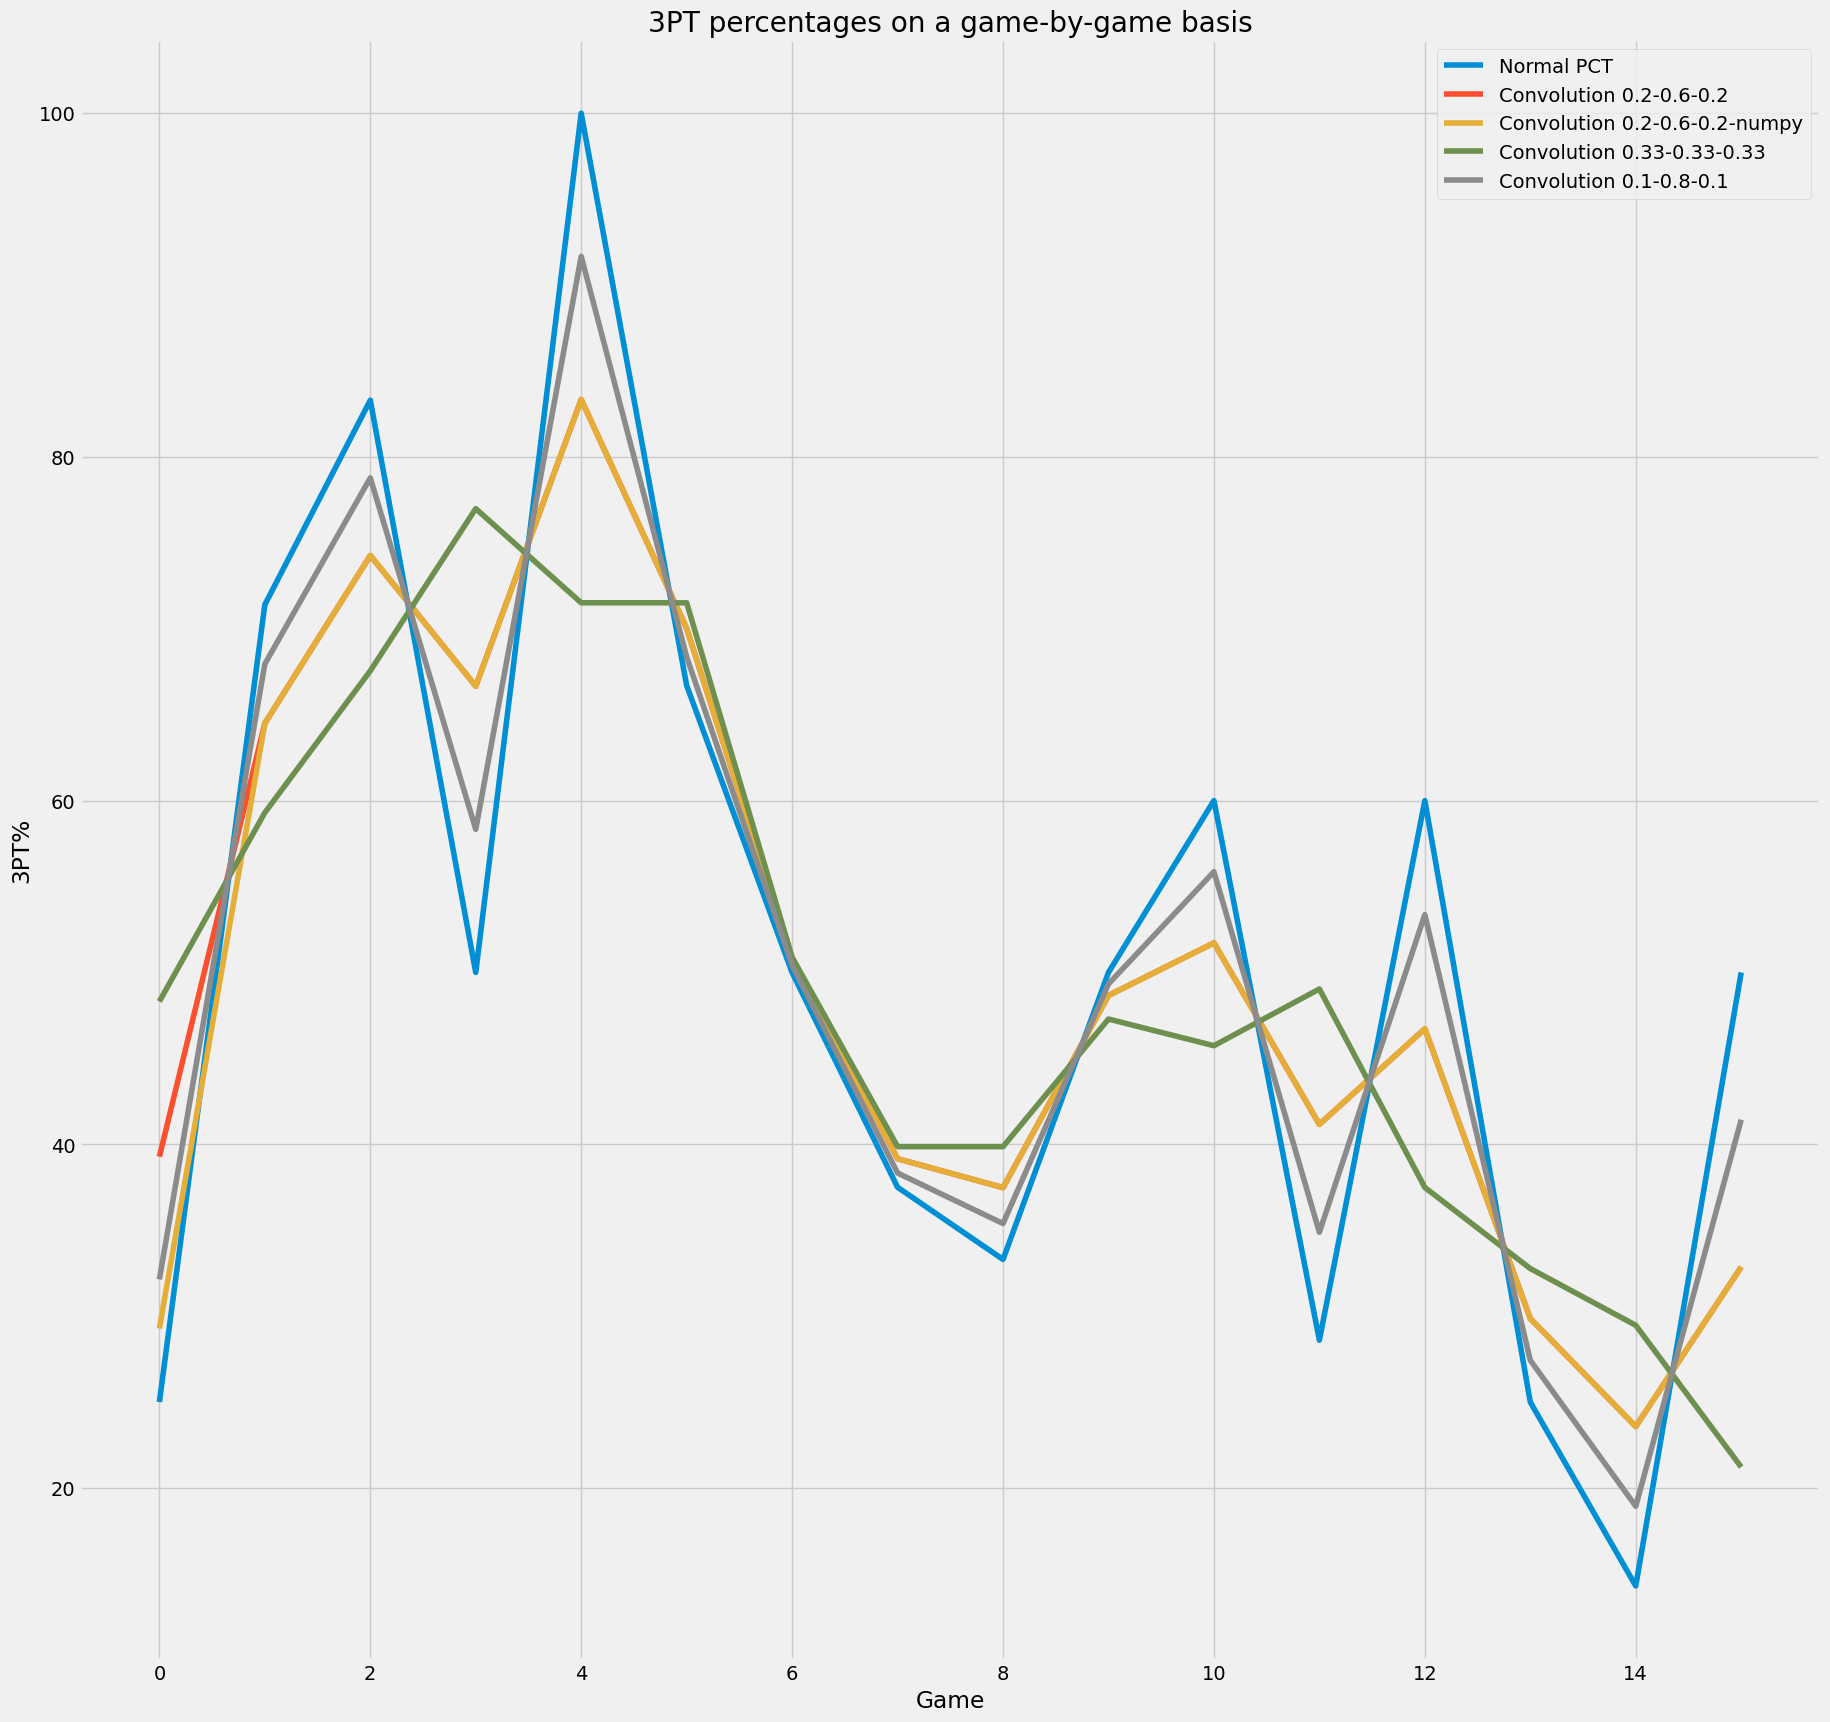

In [179]:
fig, ax = plt.subplots(figsize=(20, 20))

values = (player_game_logs.FG3_PCT* 100).tolist()
ax.plot(range(len(player_game_logs)), values, label=f"Normal PCT")

def get_smoothened(f1, f2, f3):
    smoothened = []
    for i in range(len(values)):
        smoothened.append(smooth_value(values, i, f1, f2, f3))
    return smoothened

f1, f2, f3 = 0.2, 0.6, 0.2
ax.plot(range(len(player_game_logs)), get_smoothened(f1, f2, f3), label=f"Convolution {f1}-{f2}-{f3}")
f1, f2, f3 = 0.2, 0.6, 0.2
ax.plot(range(len(player_game_logs)), np.convolve(values, (f1, f2, f3), mode='same'), label=f"Convolution {f1}-{f2}-{f3}-numpy")
f1, f2, f3 = 0.33, 0.33, 0.33
ax.plot(range(len(player_game_logs)), get_smoothened(f1, f2, f3), label=f"Convolution {f1}-{f2}-{f3}")
f1, f2, f3 = 0.1, 0.8, 0.1
ax.plot(range(len(player_game_logs)), get_smoothened(f1, f2, f3), label=f"Convolution {f1}-{f2}-{f3}")

ax.set_title('3PT percentages on a game-by-game basis')
ax.set_ylabel('3PT%')
ax.set_xlabel('Game')
plt.legend()

In [31]:
diff = int(max(top_shooters.TS_PCT.tolist())) - int(min(top_shooters.TS_PCT.tolist()))
ticks = []
min_val = int(min(top_shooters.TS_PCT.tolist()))
max_val = int(max(top_shooters.TS_PCT.tolist()))
for i in range(min_val+1, max_val+1, 5):
    ticks.append(i)
if max_val not in ticks:
    ticks.append(max_val)

In [32]:
ticks

[52, 57, 62, 67]

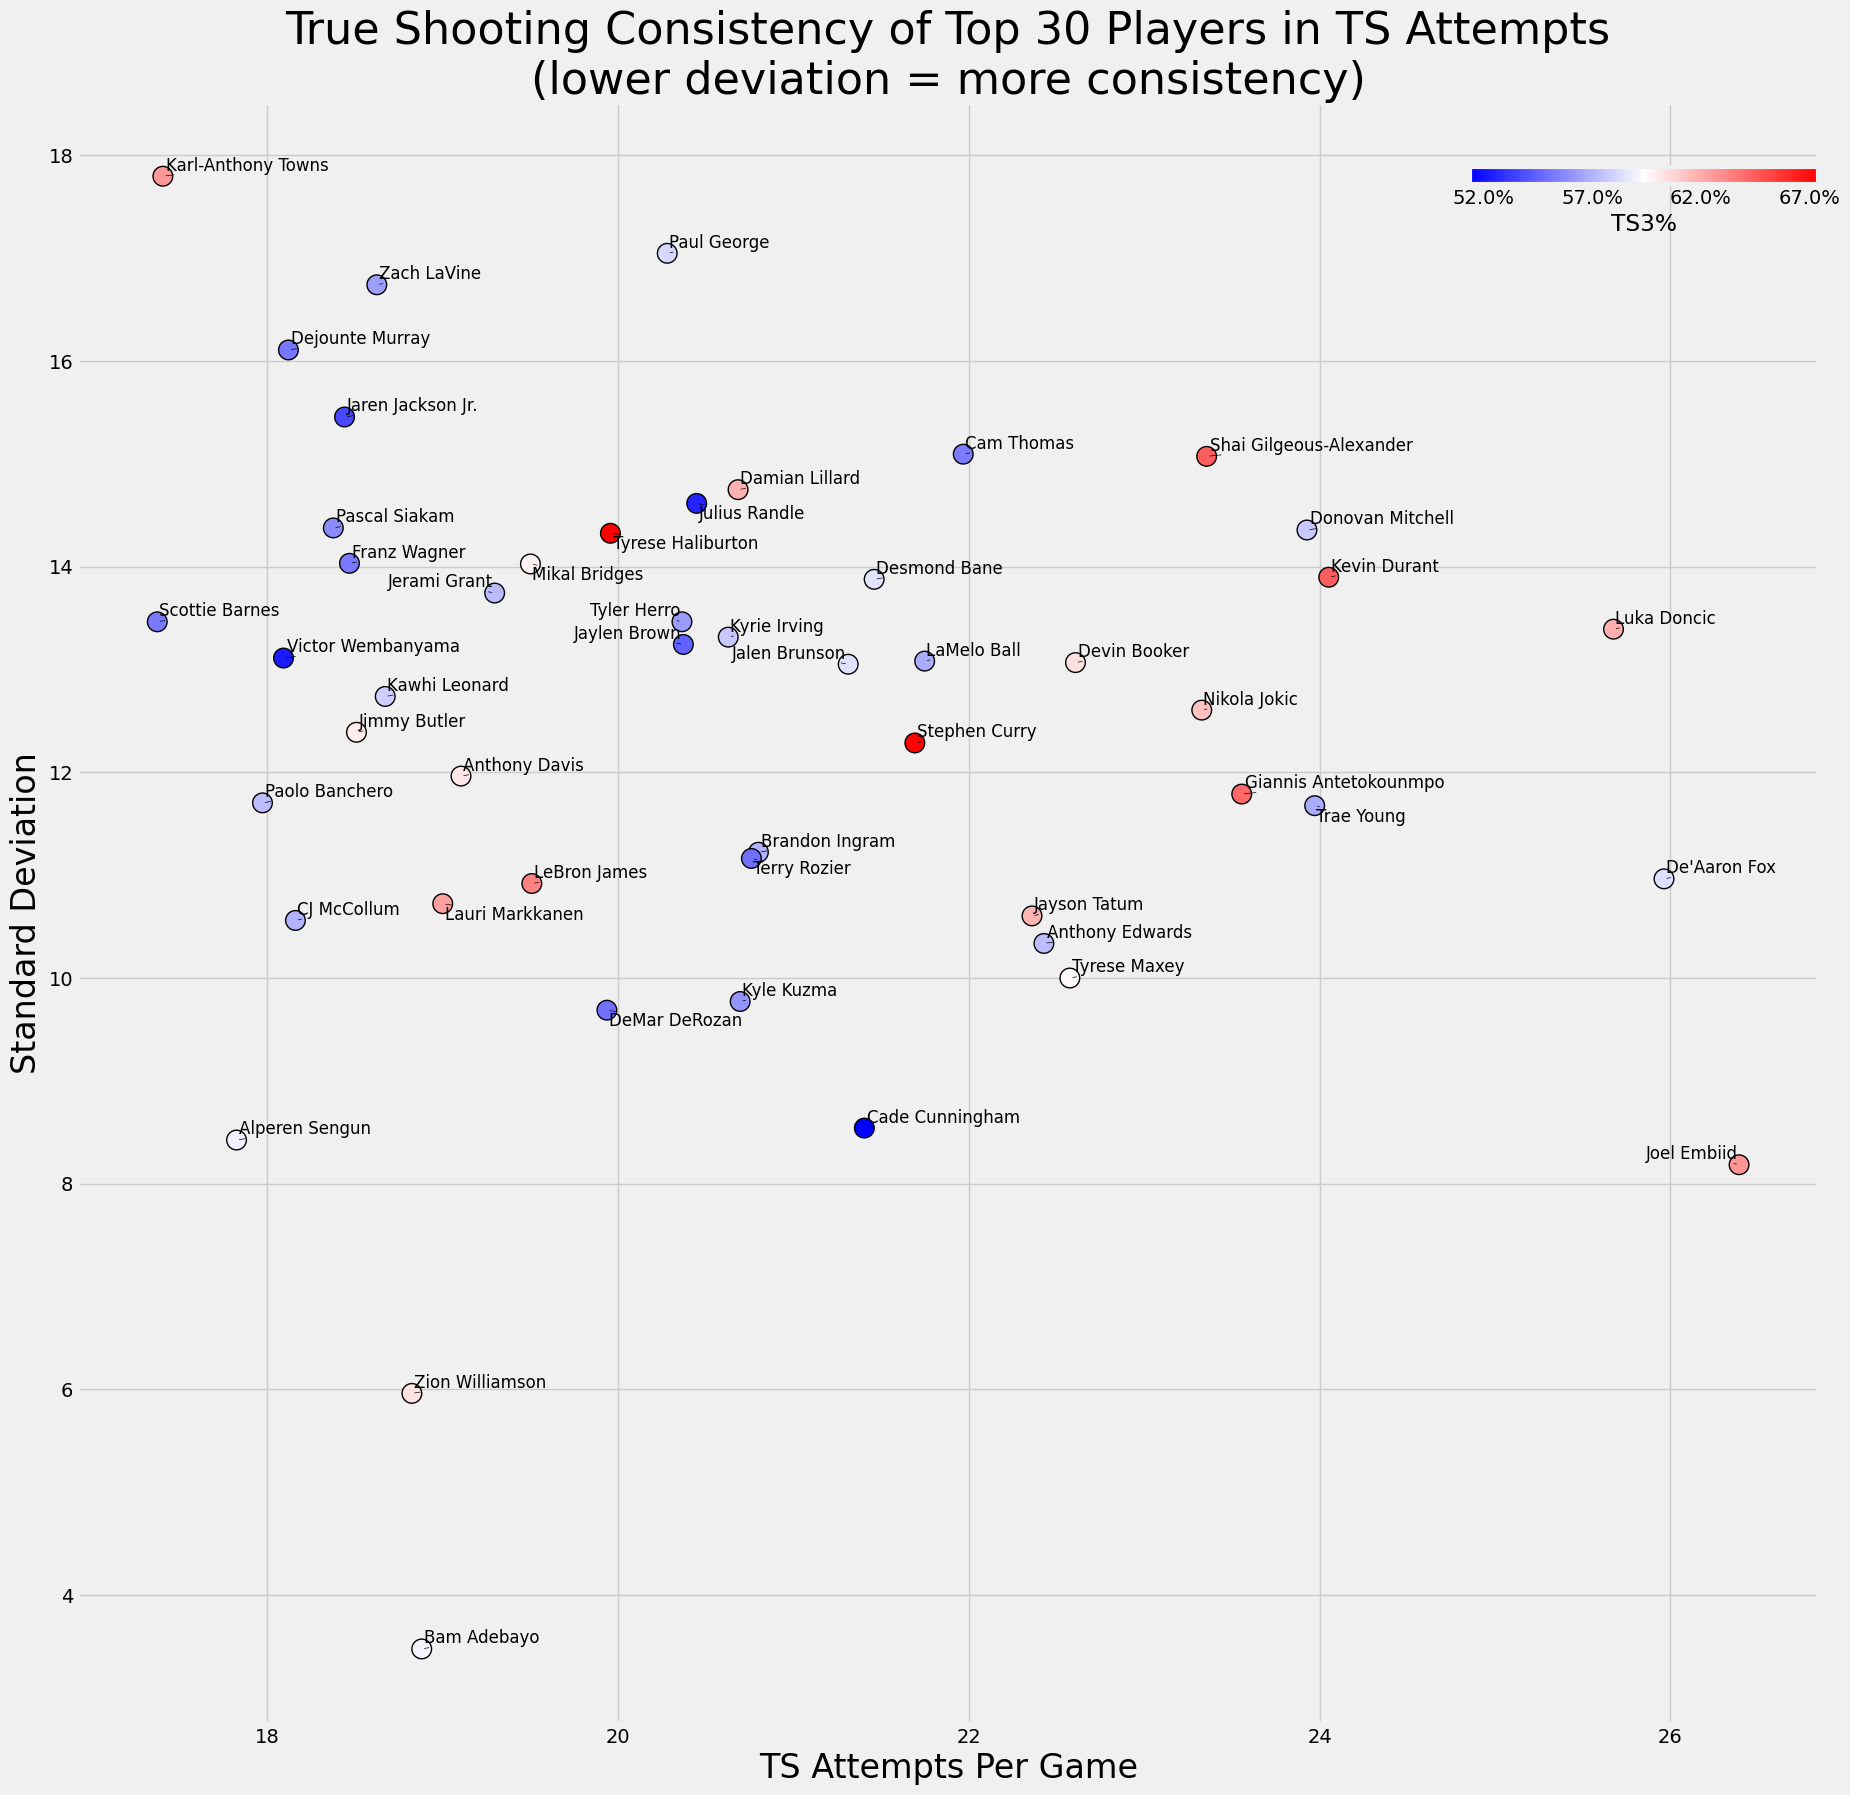

In [33]:
fig, ax = plt.subplots(figsize=(20, 20))

plot = ax.scatter(x=top_shooters.TSA, y=top_shooters.TS_PCT_DEVIATION, c=top_shooters.TS_PCT, s=200, edgecolors='black', lw=1, cmap='bwr')
#ax.yaxis.set_major_formatter()
texts = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    texts.append(ax.text(x=item.TSA, y=item.TS_PCT_DEVIATION, s=item.PLAYER_NAME, size=12))
    #ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.FG3_PCT, item.FG3_PCT_VARIANCE), frameon=False)
    #ax.add_artist(ab)

ax.set_xlabel("TS Attempts Per Game", size=24)
ax.set_ylabel("Standard Deviation", size=24)

adjust_text(texts, expand_objects=(1.5, 1.5), arrowprops={'arrowstyle': '-', 'color': 'black', 'lw': 0.5})

ax.set_title("True Shooting Consistency of Top 30 Players in TS Attempts\n(lower deviation = more consistency)", size=32)
fig.colorbar(plot, format=mtick.PercentFormatter(), label="TS3%", cax=ax.inset_axes((0.8, 0.95, 0.2, 0.01)), ticks=ticks, orientation='horizontal')

Text(0.5, 1.0, '3PT Shooting Consistency of Top 60 Players in 3PT Attempts\n(lower variance = more consistency)')

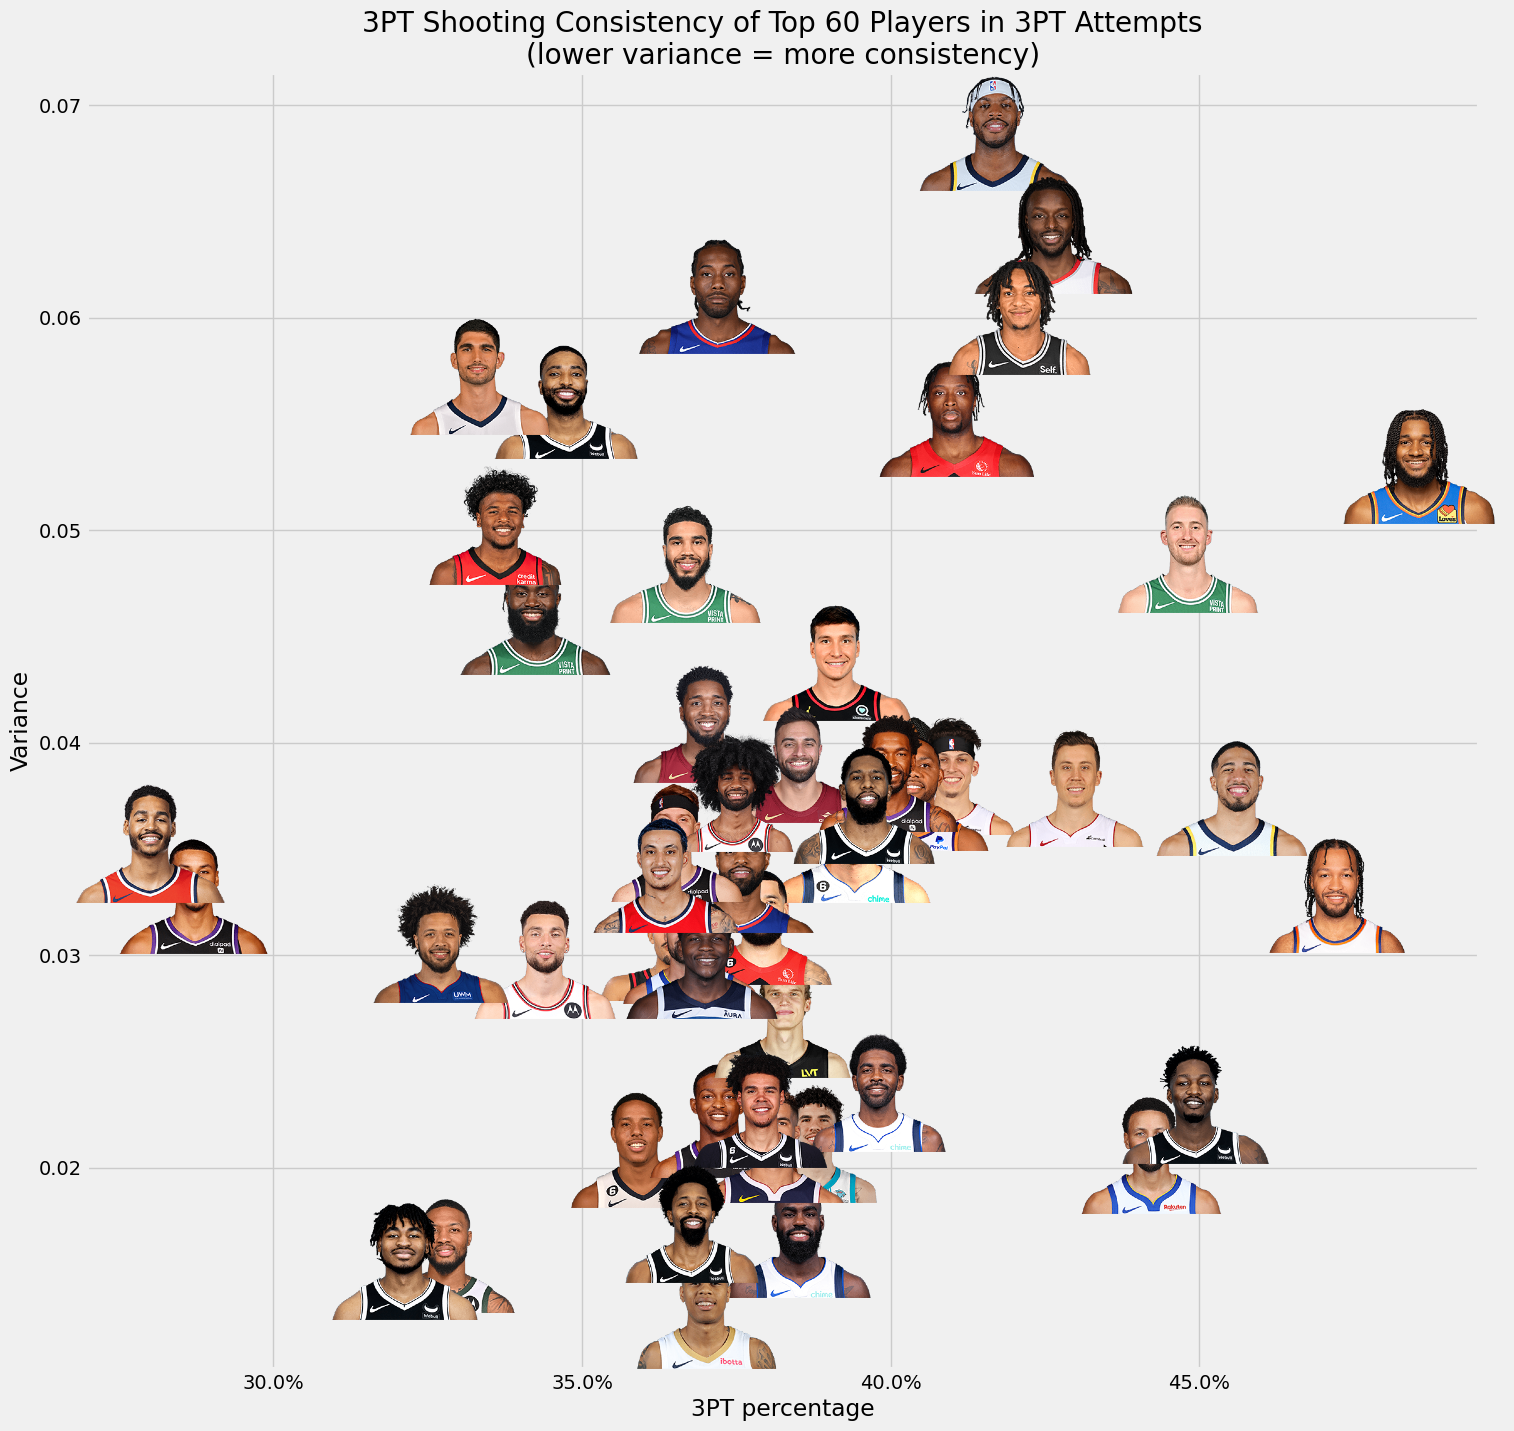

In [57]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.FG3_PCT, y=top_shooters.FG3_PCT_VARIANCE, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.FG3_PCT, item.FG3_PCT_VARIANCE), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("3PT percentage")
ax.set_ylabel("Variance")

ax.set_title("3PT Shooting Consistency of Top 60 Players in 3PT Attempts\n(lower variance = more consistency)")

Text(0.5, 1.0, 'Consistency of 3pt percentage of best shooters\n(lower deviation = more consistency)')

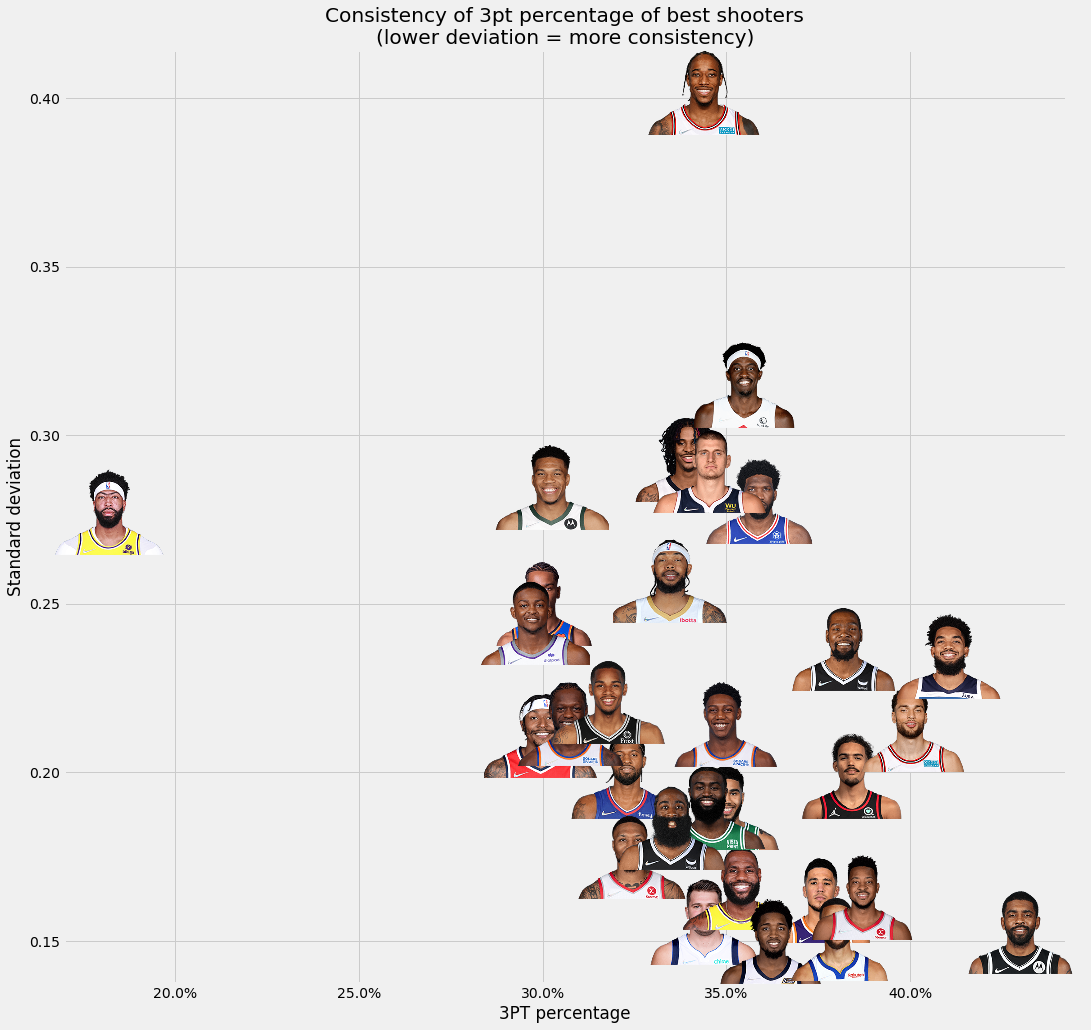

In [40]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.FG3_PCT, y=top_shooters.FG3_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.FG3_PCT, item.FG3_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("3PT percentage")
ax.set_ylabel("Standard deviation")

ax.set_title("Consistency of 3pt percentage of best shooters\n(lower deviation = more consistency)")

Text(0.5, 1.0, 'Consistency of True Shooting percentage of top 30 players by TSA in 2021-22\n(lower deviation = more consistency)')

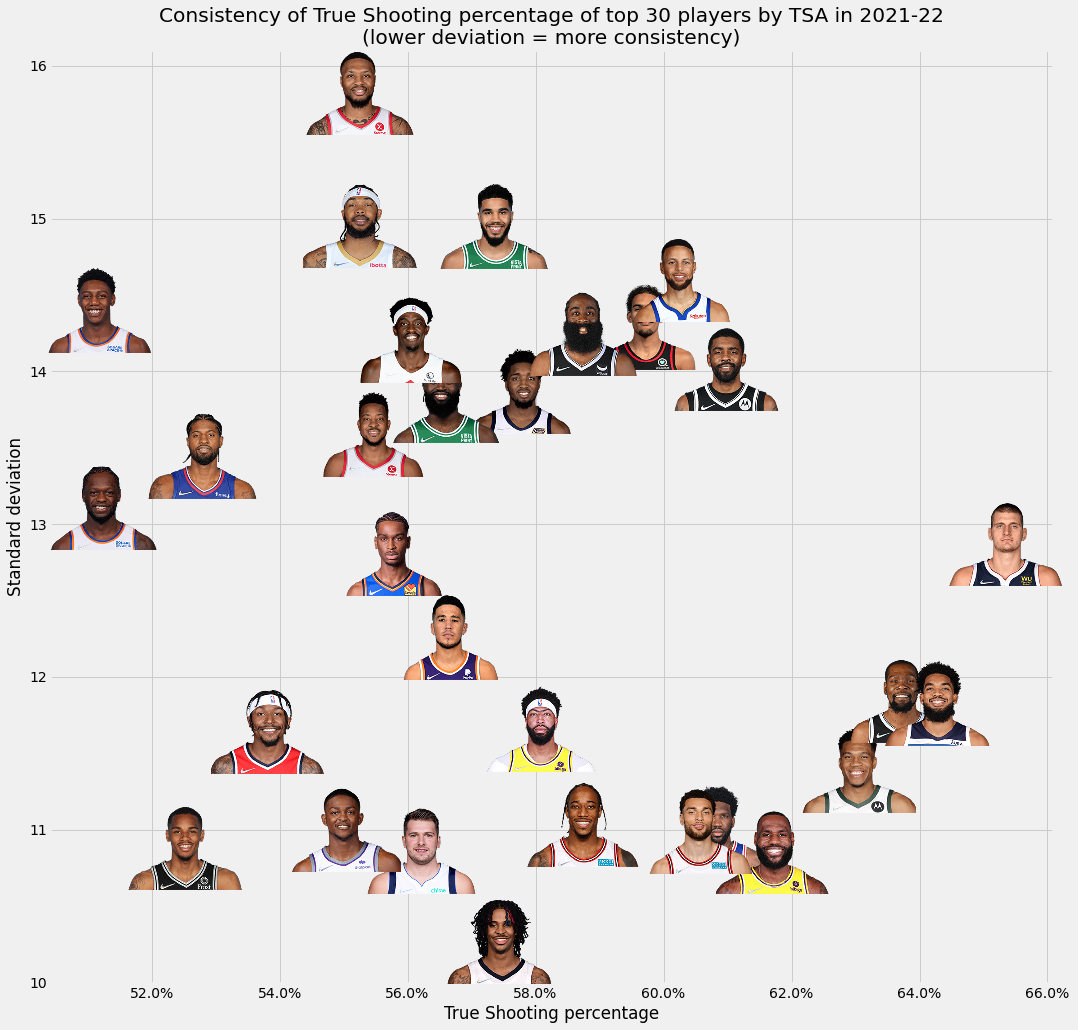

In [26]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.TS_PCT, y=top_shooters.TS_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.TS_PCT, item.TS_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("True Shooting percentage")
ax.set_ylabel("Standard deviation")

ax.set_title("Consistency of True Shooting percentage of top 30 players by TSA in 2021-22\n(lower deviation = more consistency)")

### Removing variance

#### Loading team game logs

In [11]:
team_logs = TeamGameLogs(season_nullable='2021-22').get_data_frames()[0]

In [12]:
mills_data = game_logs.loc[game_logs.PLAYER_NAME == 'Patty Mills']

In [13]:
mills_mean = mills_data.FG3M.sum() / mills_data.FG3A.sum()

In [14]:

for player_name in top_shooters.PLAYER_NAME.unique():
    player_data = game_logs.loc[game_logs.PLAYER_NAME == player_name]
    losses = 0
    print(player_name)
    for i in range(len(player_data)):
        item = player_data.iloc[i]
        single_game = team_logs.loc[team_logs.GAME_ID == item.GAME_ID]
        single_data = single_game.iloc[0]
        own_team = single_game.loc[single_game.TEAM_ID == item.TEAM_ID].iloc[0]
        other_team = single_game.loc[single_game.TEAM_ID != item.TEAM_ID].iloc[0]
        adjusted_fg3m = round(item.FG3A * mills_mean)
        adjusted_score = own_team.PTS - (item.FG3M * 3) + (adjusted_fg3m * 3)
        if adjusted_score < other_team.PTS and own_team.PTS > other_team.PTS:
            losses += 1
        print(f"\tFG3M/FG3A: {item.FG3M}/{item.FG3A}, result: {own_team.PTS}-{other_team.PTS}, adjusted FG3M/FG3A: {adjusted_fg3m}/{item.FG3A}, adjusted result: {adjusted_score} - {other_team.PTS}")
    print(f"\tTotal losses added with mean FG3%: {losses}")

NameError: name 'top_shooters' is not defined

	FG3M/FG3A: 2/4, result: 117-91, adjusted FG3M/FG3A: 2.0/4, adjusted result: 117.0 - 91
	FG3M/FG3A: 1/6, result: 105-98, adjusted FG3M/FG3A: 3.0/6, adjusted result: 111.0 - 98
	FG3M/FG3A: 5/11, result: 93-106, adjusted FG3M/FG3A: 5.0/11, adjusted result: 93.0 - 106
	FG3M/FG3A: 3/11, result: 104-90, adjusted FG3M/FG3A: 5.0/11, adjusted result: 110.0 - 90
	FG3M/FG3A: 1/3, result: 95-111, adjusted FG3M/FG3A: 1.0/3, adjusted result: 95.0 - 111
	FG3M/FG3A: 3/10, result: 114-109, adjusted FG3M/FG3A: 4.0/10, adjusted result: 117.0 - 109
	FG3M/FG3A: 3/5, result: 104-127, adjusted FG3M/FG3A: 2.0/5, adjusted result: 101.0 - 127
	Total losses added with mean FG3%: 0
Malik Beasley
	FG3M/FG3A: 7/16, result: 116-128, adjusted FG3M/FG3A: 7.0/16, adjusted result: 116.0 - 128
	FG3M/FG3A: 6/12, result: 102-114, adjusted FG3M/FG3A: 5.0/12, adjusted result: 99.0 - 114
	FG3M/FG3A: 4/12, result: 111-105, adjusted FG3M/FG3A: 5.0/12, adjusted result: 114.0 - 105
	FG3M/FG3A: 3/13, result: 110-92, adjusted FG3M

	FG3M/FG3A: 1/4, result: 104-123, adjusted FG3M/FG3A: 2.0/4, adjusted result: 107.0 - 123
	FG3M/FG3A: 1/5, result: 90-105, adjusted FG3M/FG3A: 2.0/5, adjusted result: 93.0 - 105
	FG3M/FG3A: 2/10, result: 107-96, adjusted FG3M/FG3A: 4.0/10, adjusted result: 113.0 - 96
	FG3M/FG3A: 2/4, result: 104-112, adjusted FG3M/FG3A: 2.0/4, adjusted result: 104.0 - 112
	FG3M/FG3A: 3/7, result: 97-91, adjusted FG3M/FG3A: 3.0/7, adjusted result: 97.0 - 91
	FG3M/FG3A: 2/8, result: 81-94, adjusted FG3M/FG3A: 4.0/8, adjusted result: 87.0 - 94
	FG3M/FG3A: 3/4, result: 108-120, adjusted FG3M/FG3A: 2.0/4, adjusted result: 105.0 - 120
	FG3M/FG3A: 1/1, result: 106-92, adjusted FG3M/FG3A: 0.0/1, adjusted result: 103.0 - 92
	FG3M/FG3A: 1/3, result: 90-100, adjusted FG3M/FG3A: 1.0/3, adjusted result: 90.0 - 100
	FG3M/FG3A: 2/6, result: 129-102, adjusted FG3M/FG3A: 3.0/6, adjusted result: 132.0 - 102
	FG3M/FG3A: 2/8, result: 112-109, adjusted FG3M/FG3A: 4.0/8, adjusted result: 118.0 - 109
	FG3M/FG3A: 1/2, result:

In [ ]:
own_team.PTS

In [40]:
other_team.PTS

21    115
Name: PTS, dtype: int64

## Past seasons

In [17]:
game_logs = PlayerGameLogs(season_nullable='2018-19').get_data_frames()[0]

game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

player_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season='2018-19').get_data_frames()[0]

player_stats.loc[:, 'TSA'] = player_stats.FGA + 0.44 * player_stats.FTA

top_shooters = player_stats.sort_values(by='TSA', ascending=False).iloc[:30]

top_shooters.FG3_PCT = top_shooters.FG3_PCT * 100

top_shooters.loc[:, 'TS_PCT'] = top_shooters.PTS / (2 * (top_shooters.FGA + 0.44 * top_shooters.FTA)) * 100

In [18]:

variances = []
ts_variances = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().FG3_PCT)
    ts_variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().TS_PCT)

top_shooters.loc[:, 'FG3_PCT_VARIANCE'] = variances

deviations = []
ts_deviations = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().FG3_PCT)
    ts_deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().TS_PCT)
    
top_shooters.loc[:, 'FG3_PCT_DEVIATION'] = deviations

top_shooters.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
top_shooters.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

In [19]:
for index in tqdm.tqdm(range(len(top_shooters))):
    item = top_shooters.iloc[index]
    player_id = item.PLAYER_ID
    
    path = Path(f'player_imgs/{player_id}.png').absolute()
    #print(f"Working on {player_id}")
    if path.exists():
        continue
    #img = Image.open(str(path))
    #if img.size[0] < 400:
    #    continue
    
    #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2021/260x190/{player_id}.png"
    #response = requests.get(url)
    #if response.status_code != 200:
    url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
    response = requests.get(url)
    if response.status_code != 200:
        continue
    img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)
    time.sleep(0.05)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2720.39it/s]


Text(0.5, 1.0, 'Consistency of True Shooting percentage of top 30 players by TSA in 2018-19\n(lower deviation = more consistency)')

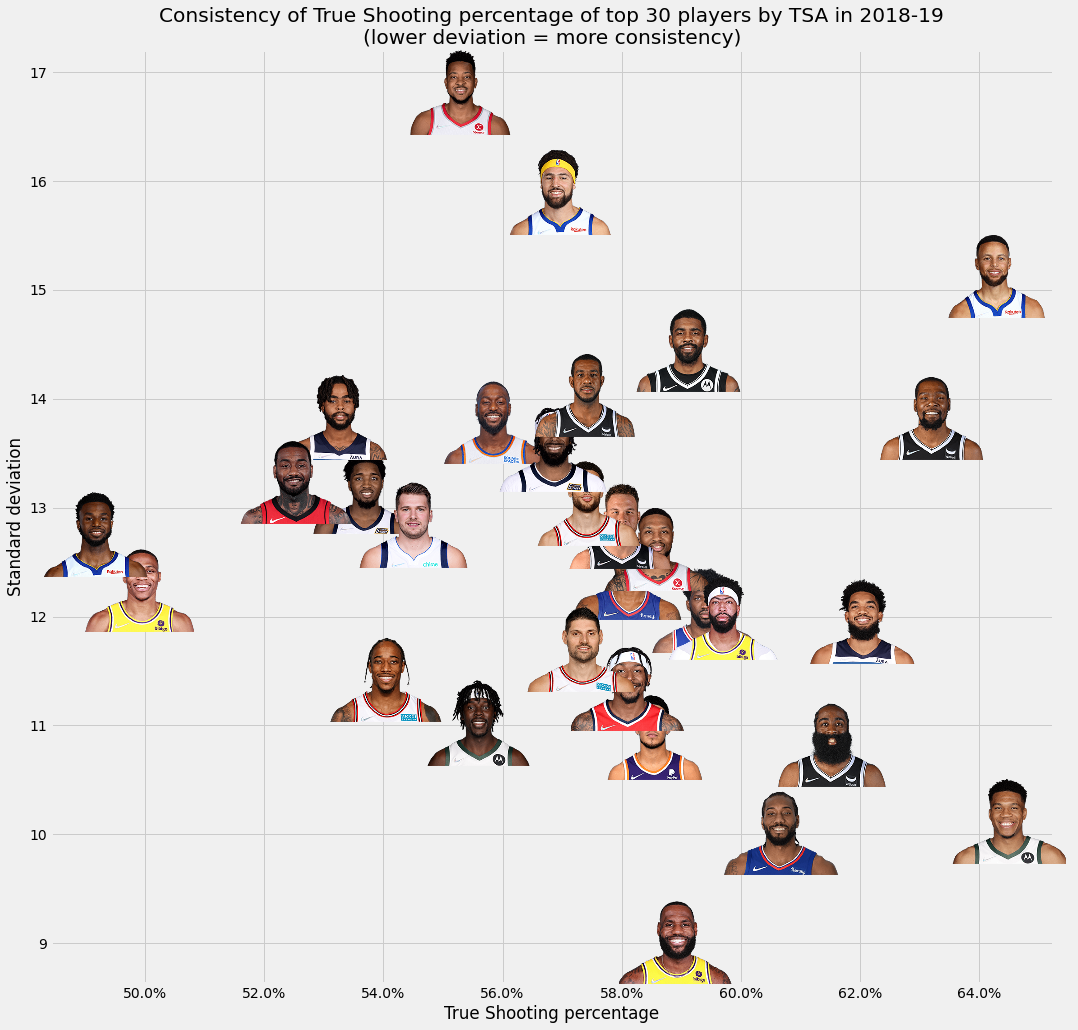

In [20]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.TS_PCT, y=top_shooters.TS_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.TS_PCT, item.TS_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("True Shooting percentage")
ax.set_ylabel("Standard deviation")

ax.set_title("Consistency of True Shooting percentage of top 30 players by TSA in 2018-19\n(lower deviation = more consistency)")

### 2020-21

In [61]:
season = '2020-21'

In [62]:
game_logs = PlayerGameLogs(season_nullable=season).get_data_frames()[0]

game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

player_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season=season).get_data_frames()[0]

player_stats.loc[:, 'TSA'] = player_stats.FGA + 0.44 * player_stats.FTA

top_shooters = player_stats.sort_values(by='TSA', ascending=False).iloc[:30]

top_shooters.FG3_PCT = top_shooters.FG3_PCT * 100

top_shooters.loc[:, 'TS_PCT'] = top_shooters.PTS / (2 * (top_shooters.FGA + 0.44 * top_shooters.FTA)) * 100

In [63]:

variances = []
ts_variances = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().FG3_PCT)
    ts_variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().TS_PCT)

top_shooters.loc[:, 'FG3_PCT_VARIANCE'] = variances

deviations = []
ts_deviations = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().FG3_PCT)
    ts_deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().TS_PCT)
    
top_shooters.loc[:, 'FG3_PCT_DEVIATION'] = deviations

top_shooters.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
top_shooters.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

In [64]:
for index in tqdm.tqdm(range(len(top_shooters))):
    item = top_shooters.iloc[index]
    player_id = item.PLAYER_ID
    
    path = Path(f'player_imgs/{player_id}.png').absolute()
    #print(f"Working on {player_id}")
    if path.exists():
        continue
    #img = Image.open(str(path))
    #if img.size[0] < 400:
    #    continue
    
    #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2021/260x190/{player_id}.png"
    #response = requests.get(url)
    #if response.status_code != 200:
    url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
    response = requests.get(url)
    if response.status_code != 200:
        continue
    img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)
    time.sleep(0.05)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2143.05it/s]


Text(0.5, 1.0, 'Consistency of True Shooting percentage of top 30 players by TSA in 2020-21\n(lower deviation = more consistency)')

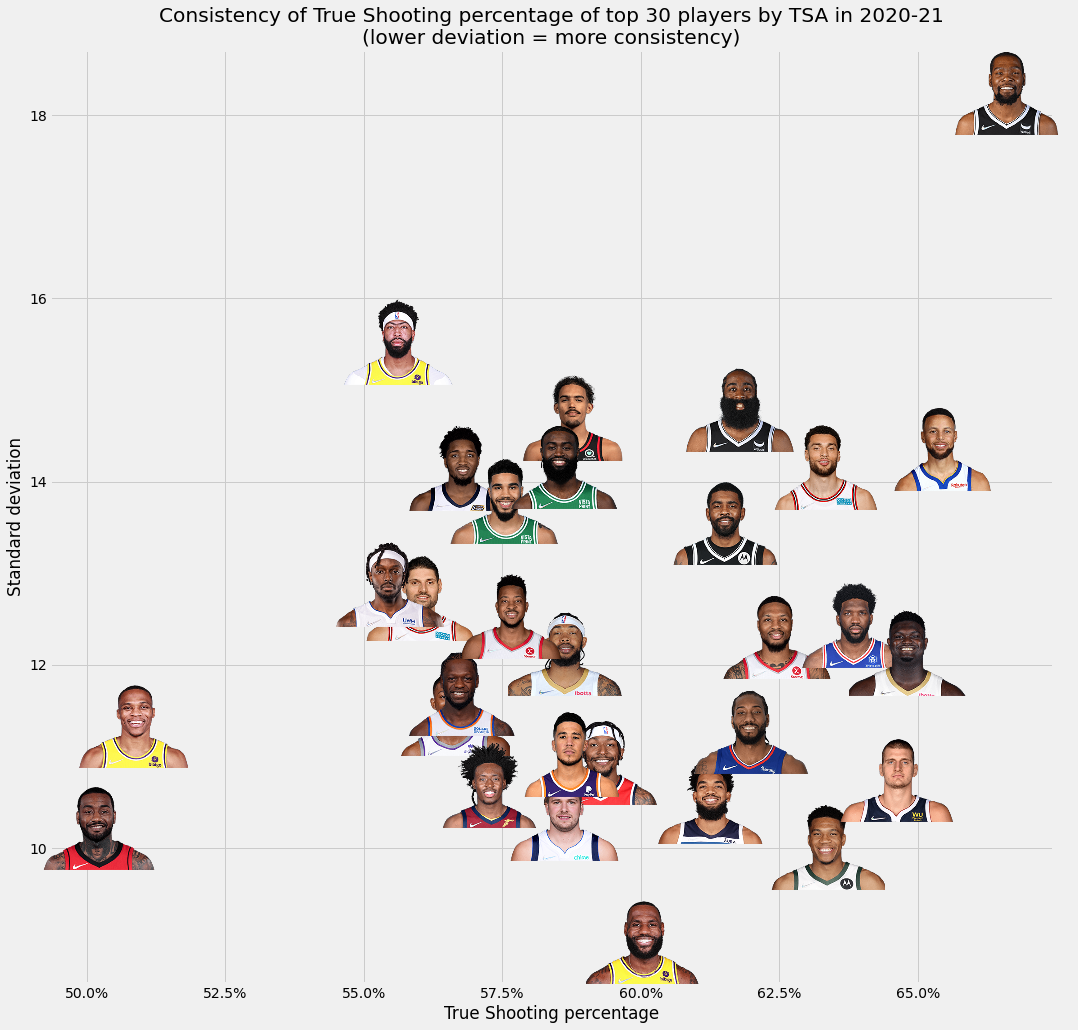

In [65]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.TS_PCT, y=top_shooters.TS_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.TS_PCT, item.TS_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("True Shooting percentage")
ax.set_ylabel("Standard deviation")

ax.set_title(f"Consistency of True Shooting percentage of top 30 players by TSA in {season}\n(lower deviation = more consistency)")

### 2019-20

In [66]:
season = '2019-20'

game_logs = PlayerGameLogs(season_nullable=season).get_data_frames()[0]

game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

player_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season=season).get_data_frames()[0]

player_stats.loc[:, 'TSA'] = player_stats.FGA + 0.44 * player_stats.FTA

top_shooters = player_stats.sort_values(by='TSA', ascending=False).iloc[:30]

top_shooters.FG3_PCT = top_shooters.FG3_PCT * 100

top_shooters.loc[:, 'TS_PCT'] = top_shooters.PTS / (2 * (top_shooters.FGA + 0.44 * top_shooters.FTA)) * 100


variances = []
ts_variances = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().FG3_PCT)
    ts_variances.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].var().TS_PCT)

top_shooters.loc[:, 'FG3_PCT_VARIANCE'] = variances

deviations = []
ts_deviations = []
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().FG3_PCT)
    ts_deviations.append(game_logs.loc[game_logs.PLAYER_NAME == item.PLAYER_NAME].std().TS_PCT)
    
top_shooters.loc[:, 'FG3_PCT_DEVIATION'] = deviations

top_shooters.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
top_shooters.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

In [67]:
for index in tqdm.tqdm(range(len(top_shooters))):
    item = top_shooters.iloc[index]
    player_id = item.PLAYER_ID
    
    path = Path(f'player_imgs/{player_id}.png').absolute()
    #print(f"Working on {player_id}")
    if path.exists():
        continue
    #img = Image.open(str(path))
    #if img.size[0] < 400:
    #    continue
    
    #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2021/260x190/{player_id}.png"
    #response = requests.get(url)
    #if response.status_code != 200:
    url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
    response = requests.get(url)
    if response.status_code != 200:
        continue
    img = Image.open(BytesIO(response.content))
    with open(f'player_imgs/{player_id}.png', 'wb') as f:
        f.write(response.content)
    time.sleep(0.05)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2000.30it/s]


Text(0.5, 1.0, 'Consistency of True Shooting percentage of top 30 players by TSA in 2019-20\n(lower deviation = more consistency)')

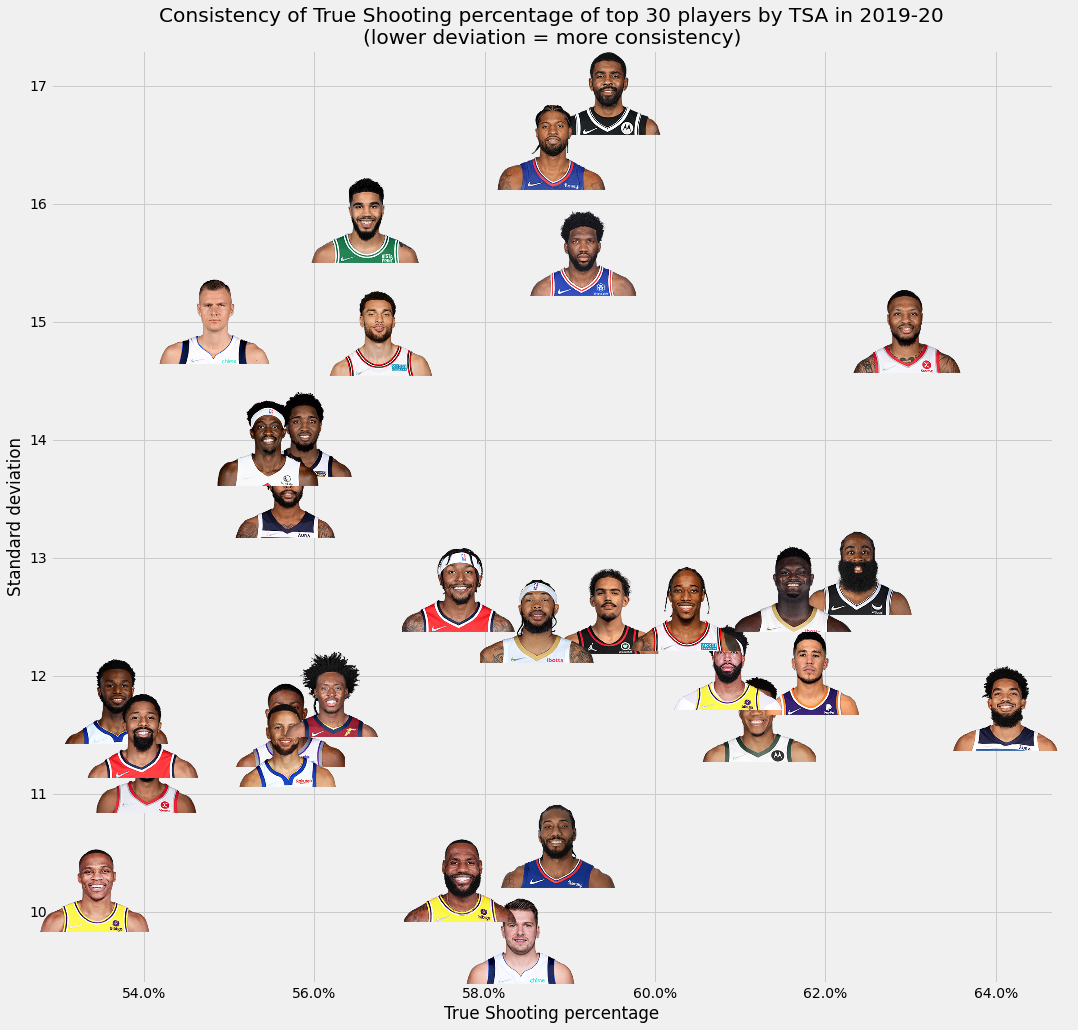

In [68]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=top_shooters.TS_PCT, y=top_shooters.TS_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(top_shooters)):
    item = top_shooters.iloc[i]
    ab = AnnotationBbox(get_player_img(item.PLAYER_ID), (item.TS_PCT, item.TS_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("True Shooting percentage")
ax.set_ylabel("Standard deviation")

ax.set_title(f"Consistency of True Shooting percentage of top 30 players by TSA in {season}\n(lower deviation = more consistency)")

## Team Variance

In [15]:
season = "2023-24"
team_stats = LeagueDashTeamStats(per_mode_detailed='PerGame', season=season).get_data_frames()[0]

team_stats.loc[:, 'TSA'] = team_stats.FGA + 0.44 * team_stats.FTA

team_stats.FG3_PCT = team_stats.FG3_PCT * 100

team_stats.loc[:, 'TS_PCT'] = team_stats.PTS / (2 * (team_stats.FGA + 0.44 * team_stats.FTA)) * 100


In [16]:
game_logs = TeamGameLogs(season_nullable=season).get_data_frames()[0]

In [17]:
game_logs.loc[:, 'TS_PCT'] = game_logs.PTS / (2 * (game_logs.FGA + 0.44 * game_logs.FTA)) * 100

In [18]:
game_logs.loc[:, 'FG3_PCT'] = game_logs.FG3_PCT * 100

In [19]:

variances = []
ts_variances = []
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    variances.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].FG3_PCT.var(ddof=0))
    ts_variances.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].TS_PCT.var(ddof=0))

team_stats.loc[:, 'FG3_PCT_VARIANCE'] = variances

deviations = []
ts_deviations = []
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    deviations.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].FG3_PCT.std(ddof=0))
    ts_deviations.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].TS_PCT.std(ddof=0))
    
team_stats.loc[:, 'FG3_PCT_DEVIATION'] = deviations

team_stats.loc[:, 'TS_PCT_DEVIATION'] = ts_deviations
team_stats.loc[:, 'TS_PCT_VARIANCE'] = ts_variances

Text(0.5, 1.0, 'Consistency of 3pt percentage of teams in 2023-24\n(lower deviation = more consistency)')

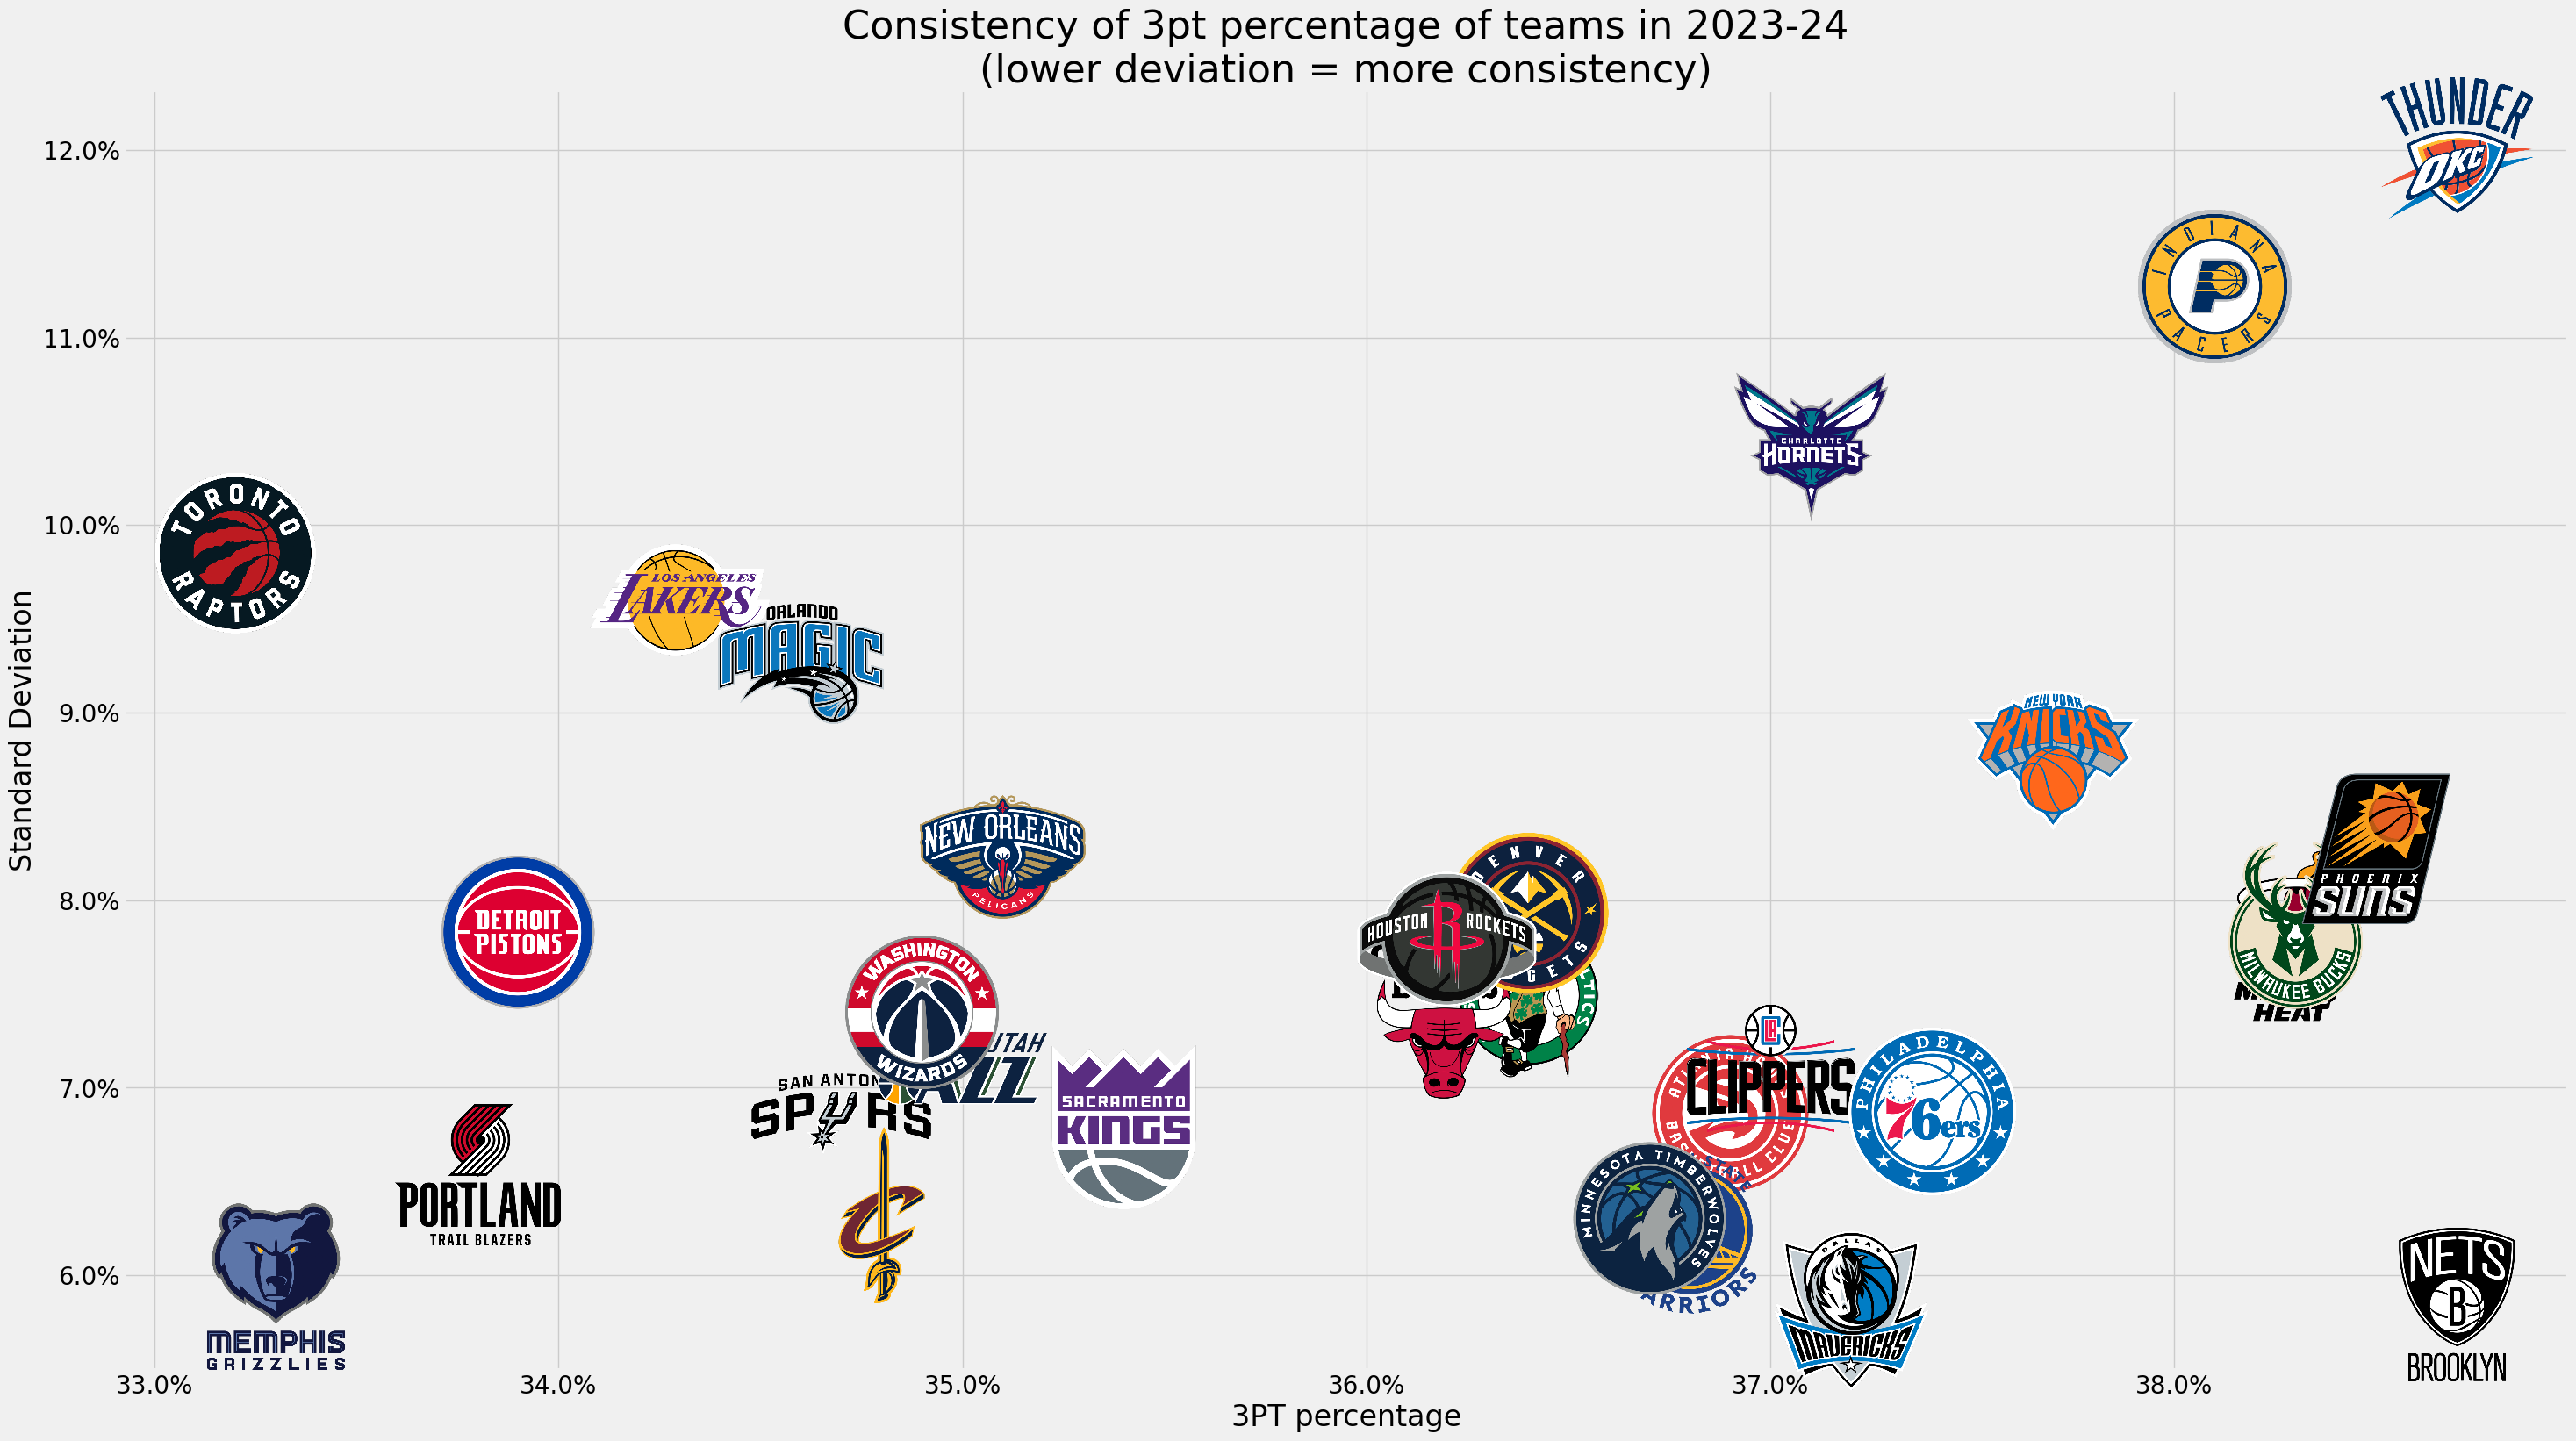

In [20]:
fig, ax = plt.subplots(figsize=(32, 18))

ax.scatter(x=team_stats.FG3_PCT, y=team_stats.FG3_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID, zoom=0.2), (item.FG3_PCT, item.FG3_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("3PT percentage", size=24,)
ax.set_ylabel("Standard Deviation", size=24)
ax.tick_params(which='both', labelsize=20)
ax.set_title(f"Consistency of 3pt percentage of teams in {season}\n(lower deviation = more consistency)", size=32)

Text(0.5, 1.0, 'Consistency of 3pt percentage of teams in 2023-24\n(lower deviation = more consistency)')

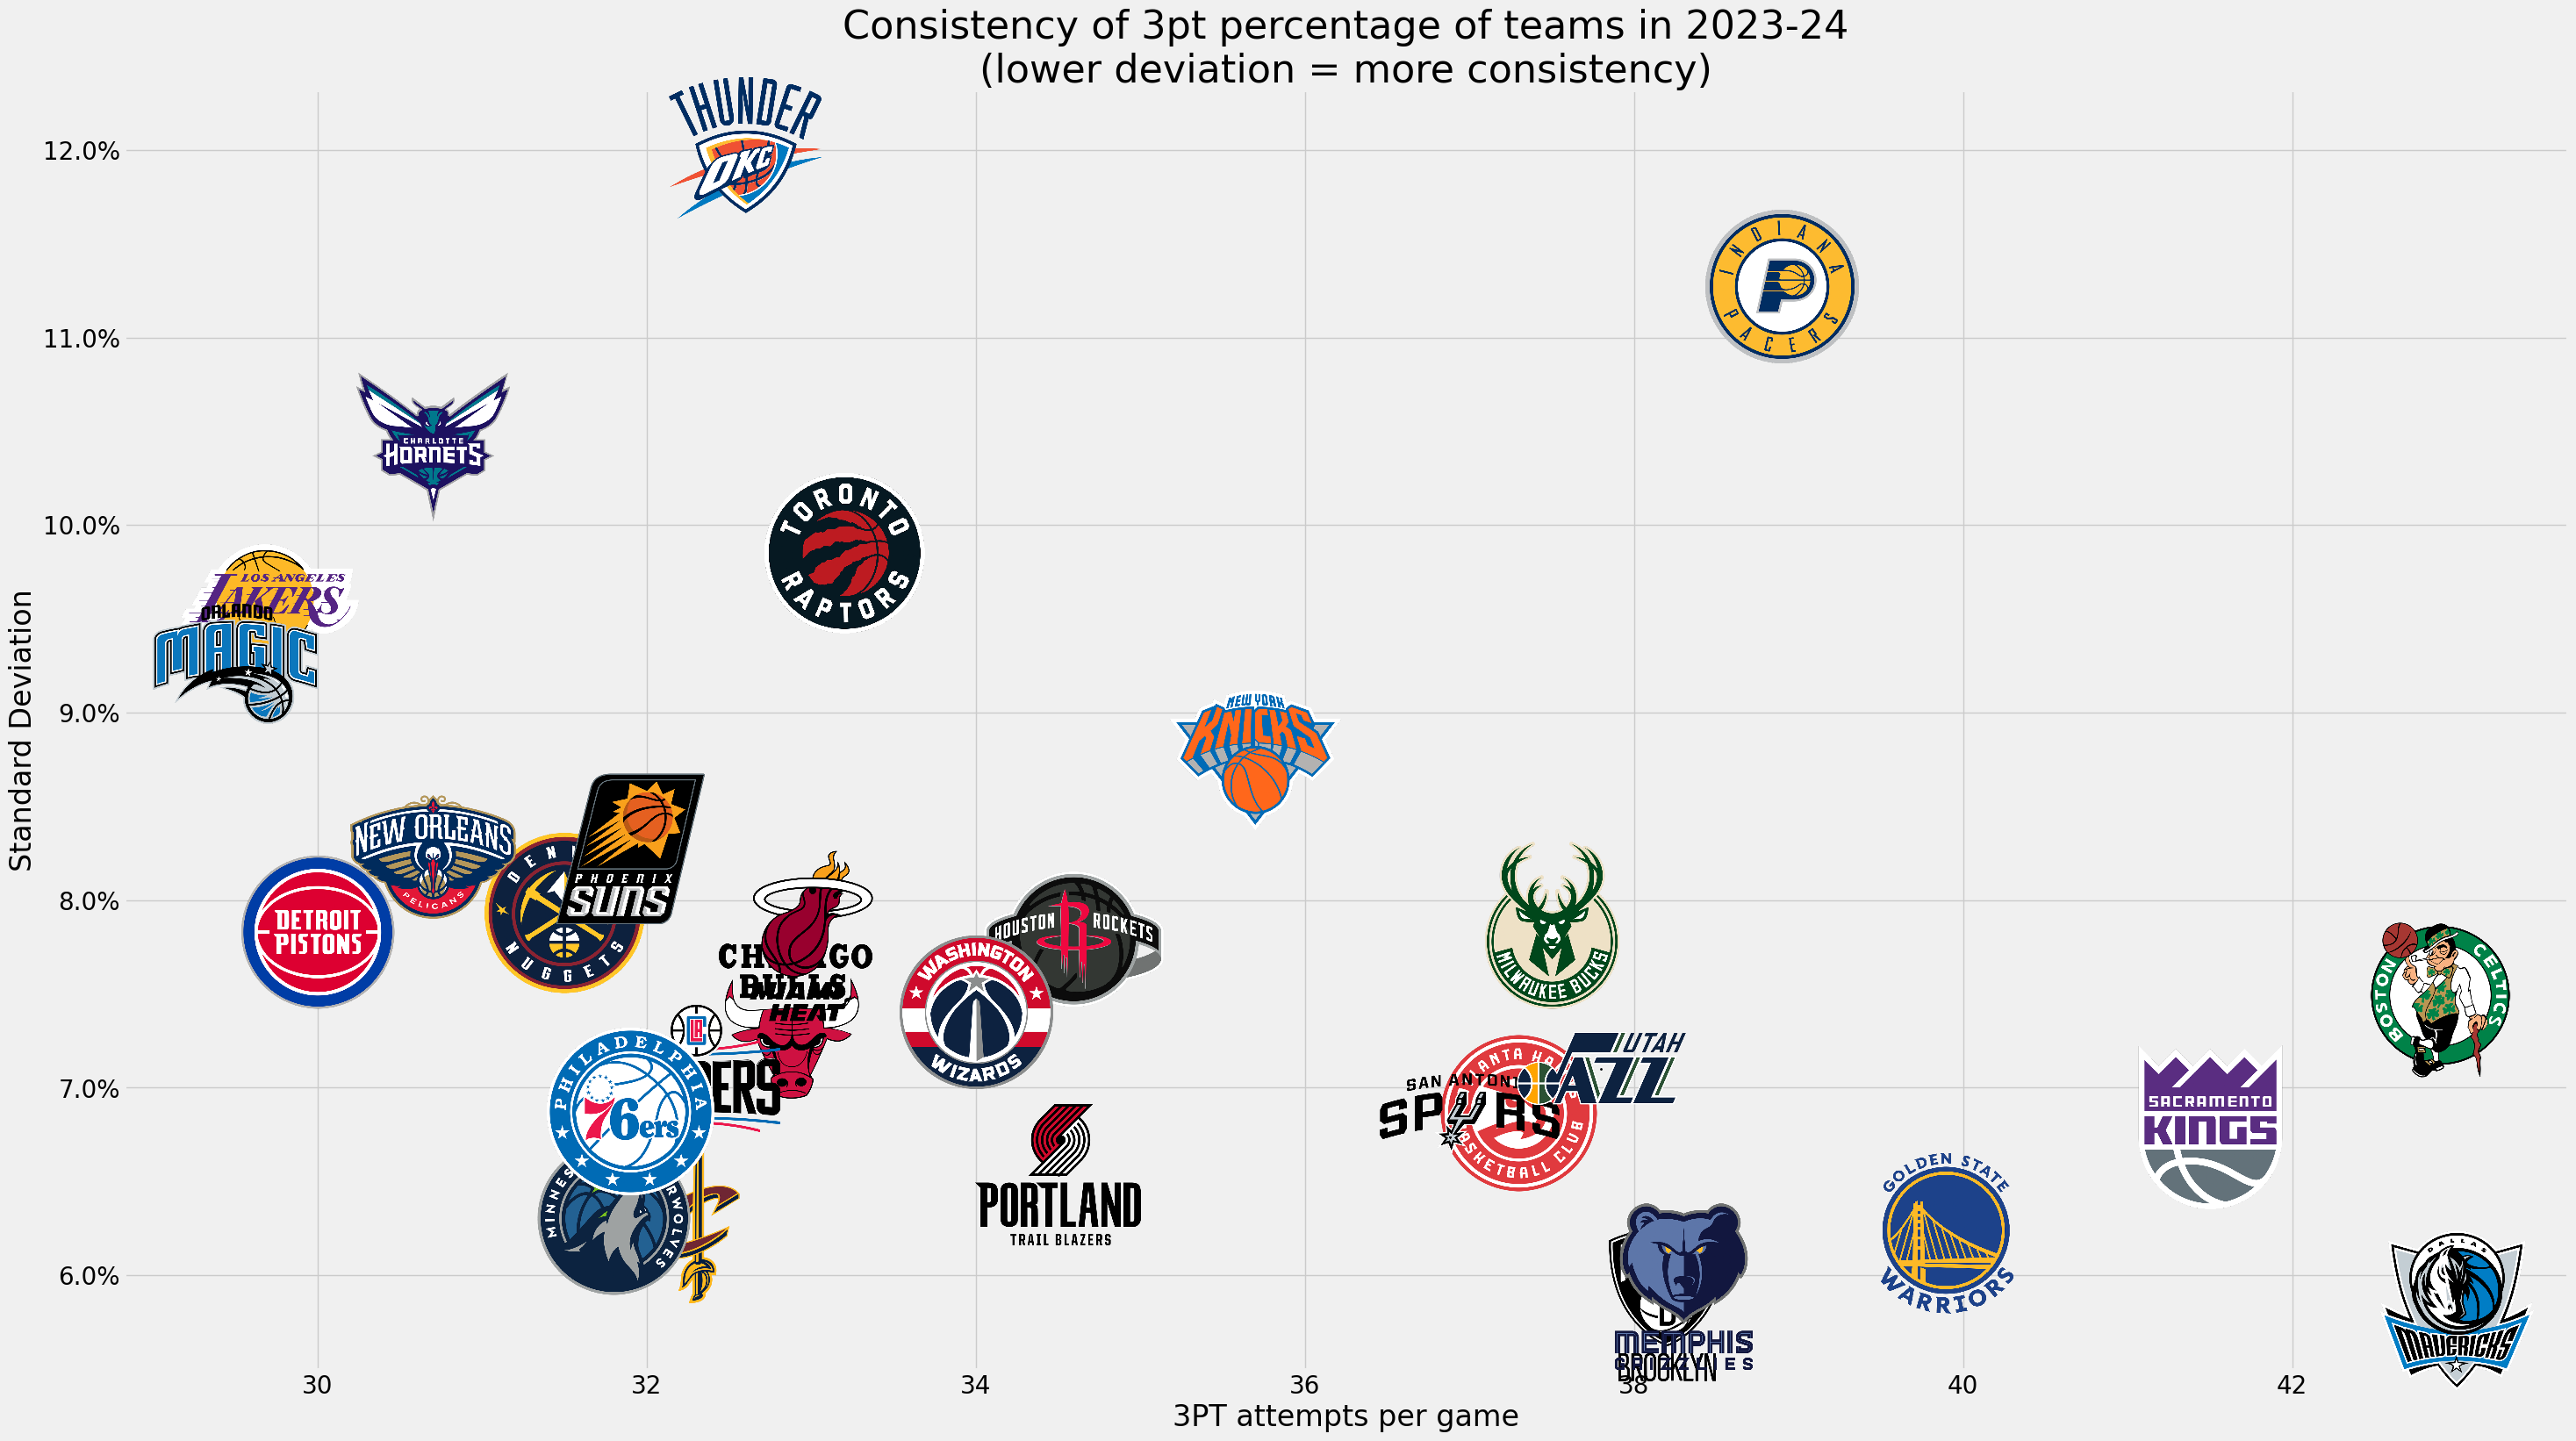

In [24]:
fig, ax = plt.subplots(figsize=(32, 18))

ax.scatter(x=team_stats.FG3A, y=team_stats.FG3_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
#ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID, zoom=0.2), (item.FG3A, item.FG3_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("3PT attempts per game", size=24,)
ax.set_ylabel("Standard Deviation", size=24)
ax.tick_params(which='both', labelsize=20)
ax.set_title(f"Consistency of 3pt percentage of teams in {season}\n(lower deviation = more consistency)", size=32)

This chart shows the deviation of team's 3pt% percentage through the games this seaosn. Jazz are rock solid and consistent, while the Celtics are most volatile?



Text(0.5, 1.0, 'Consistency of True Shooting Percentage of teams in 2023-24\n(lower deviation = more consistency)')

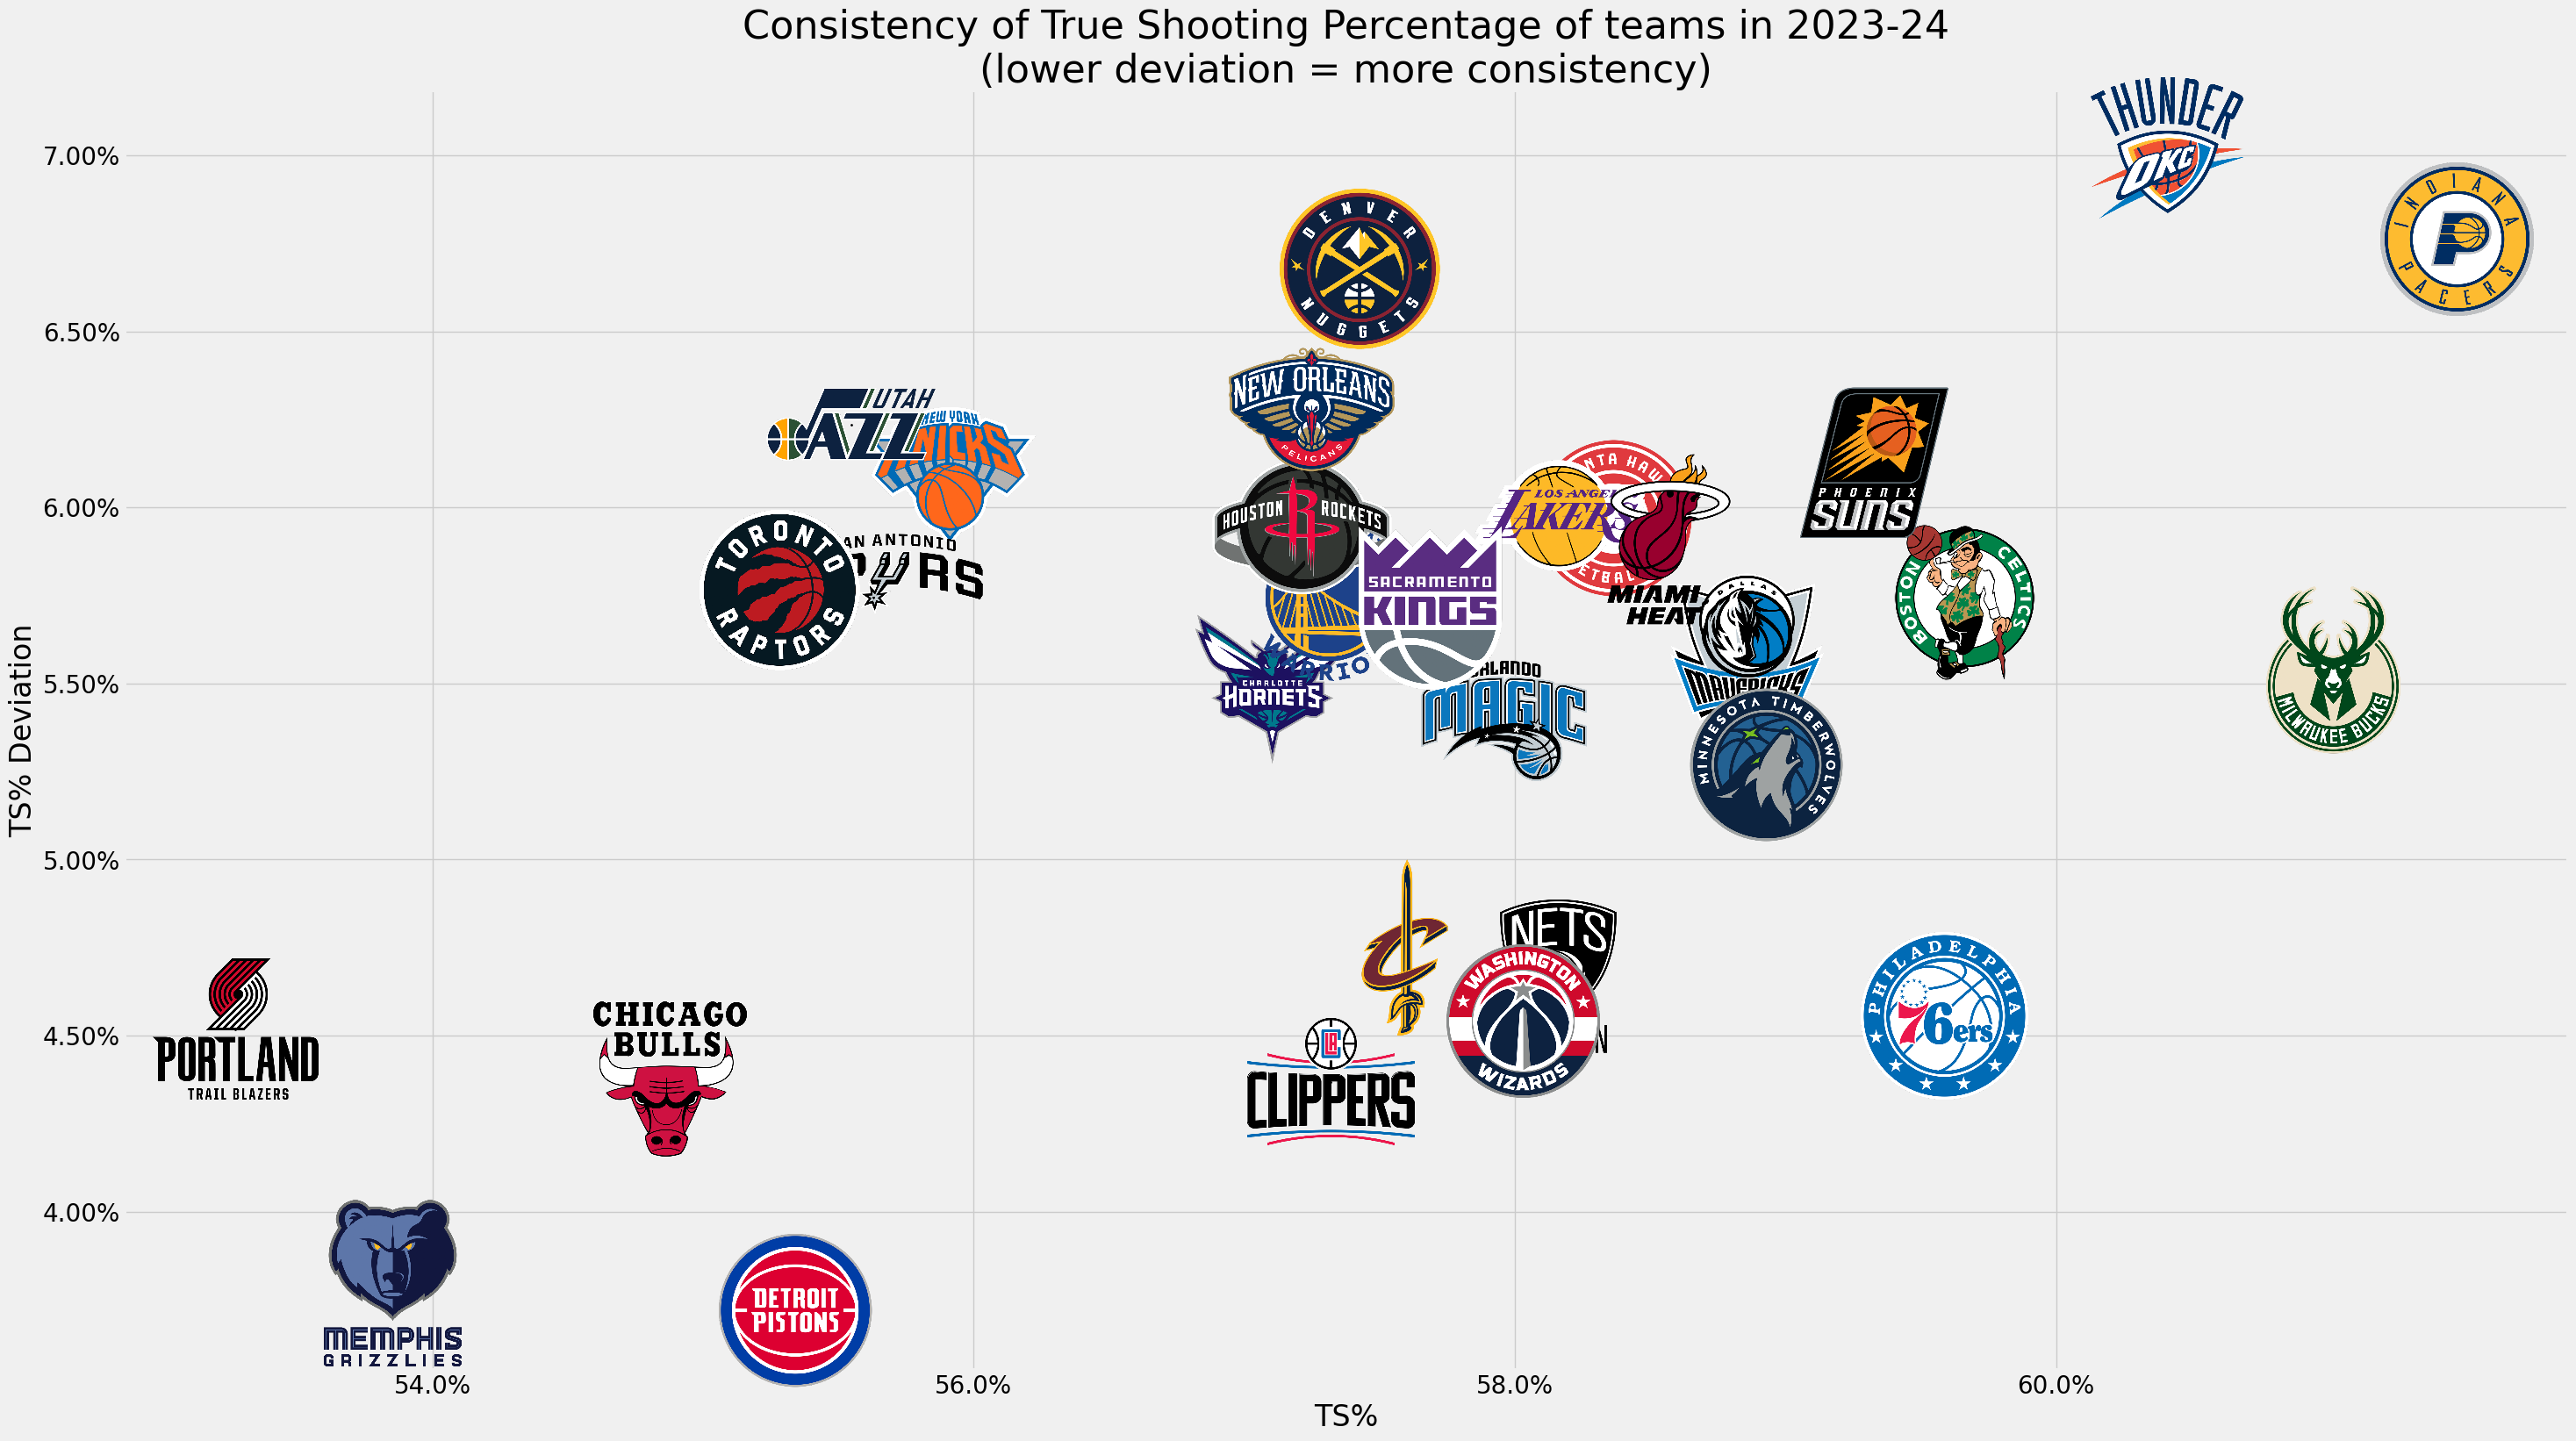

In [21]:
fig, ax = plt.subplots(figsize=(32, 18))

ax.scatter(x=team_stats.TS_PCT, y=team_stats.TS_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID, zoom=0.2), (item.TS_PCT, item.TS_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel("TS%", size=24)
ax.set_ylabel("TS% Deviation", size=24)
ax.tick_params(which='both', labelsize=20)
ax.set_title(f"Consistency of True Shooting Percentage of teams in {season}\n(lower deviation = more consistency)", size=32)

## Wide Open Shots

In [28]:
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder

In [29]:
finder = LeagueGameFinder(league_id_nullable='00', season_type_nullable='Regular Season', season_nullable=season)

In [30]:
schedule_df = finder.get_data_frames()[0]

In [35]:
date = '2022-02-08'

In [36]:
format_date = f"{date.split('-')[1]}/{date.split('-')[2]}/{date.split('-')[0]}"

In [37]:
format_date

'02/08/2022'

In [38]:
date

'2022-02-08'

In [39]:
wide_open_df = LeagueDashTeamPtShot(per_mode_simple='PerGame', season=season, close_def_dist_range_nullable='6+ Feet - Wide Open', date_from_nullable=format_date, date_to_nullable=format_date).get_data_frames()[0]

In [40]:
data_frames = []
for cur_date in tqdm.tqdm(sorted(schedule_df.GAME_DATE.unique())):
    wide_open_df = LeagueDashTeamPtShot(per_mode_simple='PerGame', season=season, close_def_dist_range_nullable='6+ Feet - Wide Open', date_from_nullable=cur_date, date_to_nullable=cur_date).get_data_frames()[0]
    data_frames.append(wide_open_df)
    time.sleep(0.5)
    


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:26<00:00,  2.28s/it]


In [41]:
full_wide_open_df = pd.concat(data_frames)

In [42]:
full_wide_open_df.loc[:, 'FG3_PCT'] = full_wide_open_df.FG3_PCT * 100

In [62]:
full_wide_open_df.loc[full_wide_open_df.TEAM_ABBREVIATION == 'GSW'].loc[:, ['TEAM_ABBREVIATION', 'FG3M', 'FG3A', 'FG3_PCT']]

TEAM_ABBREVIATION  FG3M  FG3A  FG3_PCT
3                GSW   5.0  14.0     35.7
6                GSW   8.0  19.0     42.1
11               GSW   7.0  16.0     43.8
5                GSW  10.0  22.0     45.5
23               GSW   6.0  14.0     42.9
2                GSW  12.0  26.0     46.2
6                GSW  10.0  20.0     50.0
11               GSW   4.0  16.0     25.0
4                GSW   6.0  14.0     42.9
8                GSW   8.0  20.0     40.0
8                GSW   5.0  19.0     26.3
5                GSW  11.0  20.0     55.0
7                GSW   7.0  20.0     35.0
15               GSW   5.0  14.0     35.7
0                GSW  11.0  27.0     40.7
10               GSW   9.0  20.0     45.0
6                GSW   8.0  21.0     38.1
4                GSW   9.0  23.0     39.1

In [43]:
total_wide_open = LeagueDashTeamPtShot(per_mode_simple='PerGame', season=season, close_def_dist_range_nullable='6+ Feet - Wide Open').get_data_frames()[0]

In [44]:
total_wide_open.loc[:, 'FG3_PCT'] = total_wide_open.FG3_PCT * 100

In [45]:
variances = []
deviations = []

for team_name in total_wide_open.TEAM_NAME.tolist():
    team_only_df = full_wide_open_df.loc[full_wide_open_df.TEAM_NAME == team_name]
    mean = total_wide_open.loc[total_wide_open.TEAM_NAME == team_name].iloc[0].FG3_PCT
    var_sum = 0
    for item in team_only_df.iterrows():
        var_sum += (item[1].FG3_PCT - mean) ** 2
    deviations.append((var_sum / len(team_only_df)) ** 0.5)

In [46]:
total_wide_open.loc[:, 'FG3_PCT_DEVIATION'] = deviations

Text(0.5, 1.0, 'Consistency of WIDE OPEN 3pt percentage of teams in 2023-24\n(lower deviation = more consistency)')

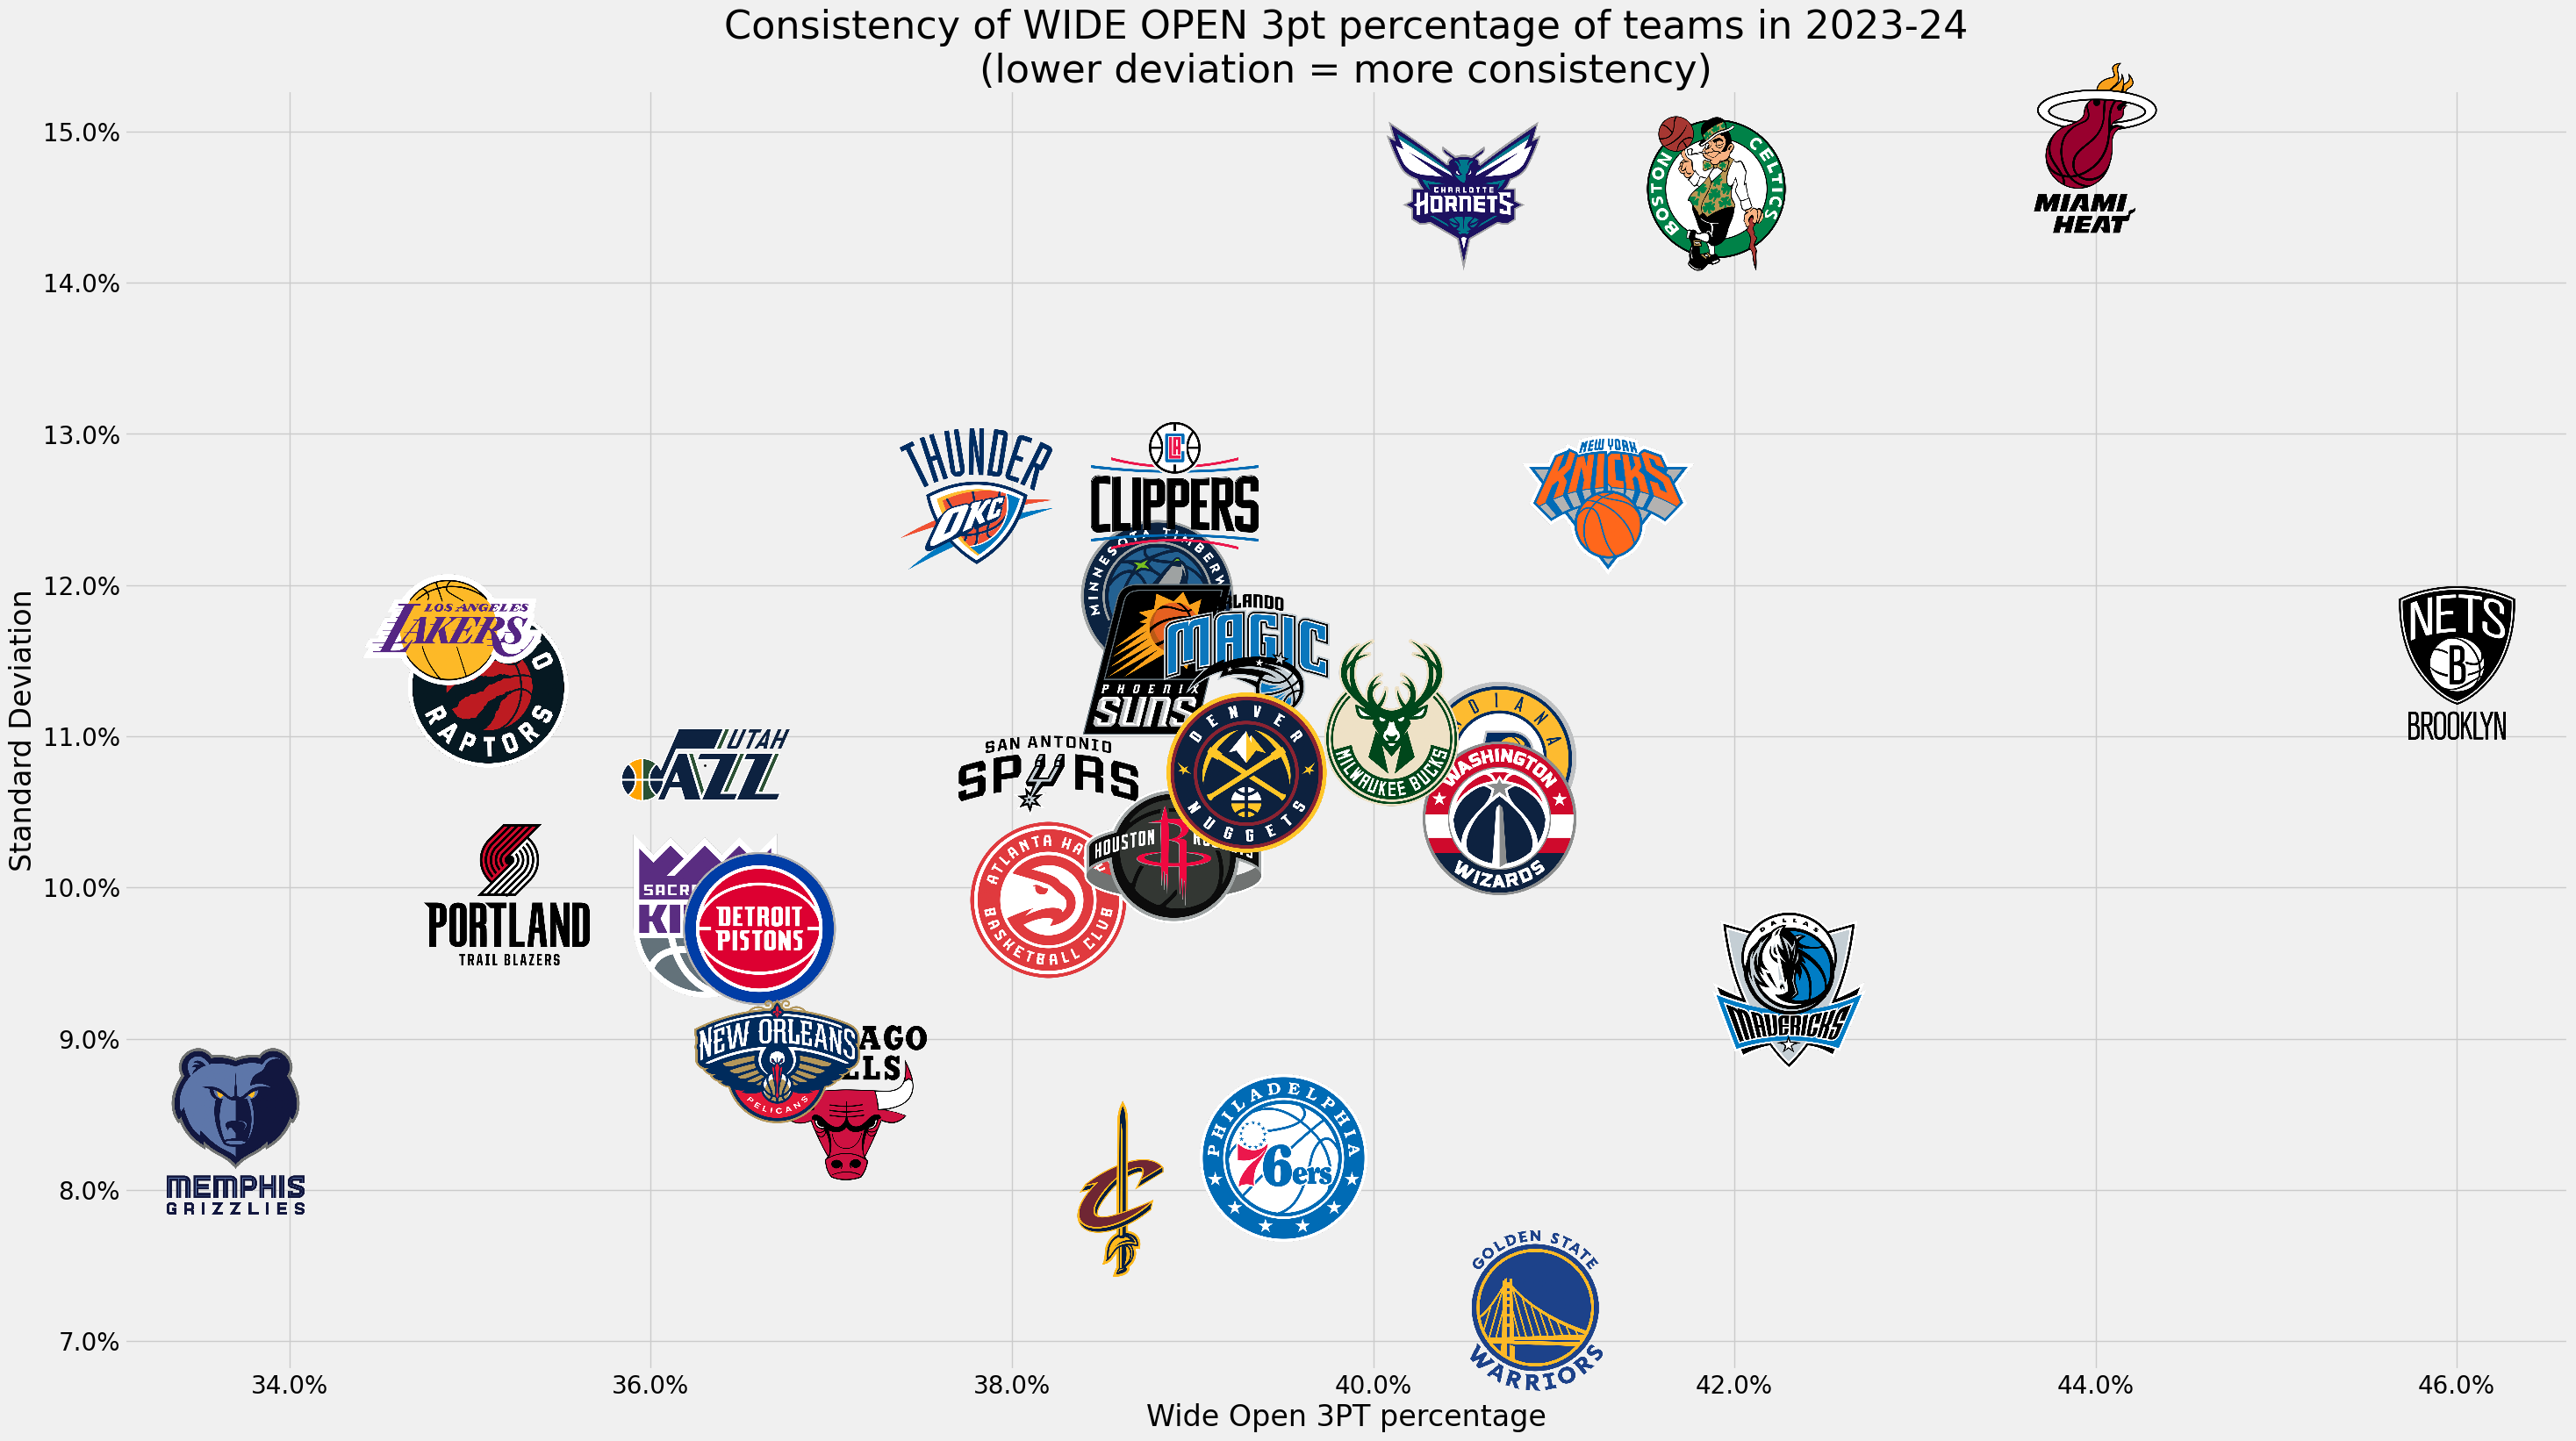

In [63]:
fig, ax = plt.subplots(figsize=(32, 18))

ax.scatter(x=total_wide_open.FG3_PCT, y=total_wide_open.FG3_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(total_wide_open)):
    item = total_wide_open.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID, zoom=0.2), (item.FG3_PCT, item.FG3_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("Wide Open 3PT percentage", size=24)
ax.set_ylabel("Standard Deviation", size=24)
ax.tick_params(which='both', labelsize=20)

ax.set_title(f"Consistency of WIDE OPEN 3pt percentage of teams in {season}\n(lower deviation = more consistency)", size=32)

In [51]:

team_stats = LeagueDashTeamStats(per_mode_detailed='PerGame', season=season).get_data_frames()[0]
team_stats.FG3_PCT = team_stats.FG3_PCT * 100


In [52]:
game_logs = TeamGameLogs(season_nullable=season).get_data_frames()[0]
game_logs.loc[:, 'FG3_PCT'] = game_logs.FG3_PCT * 100

In [54]:

deviations = []
ts_deviations = []
for i in range(len(team_stats)):
    item = team_stats.iloc[i]
    deviations.append(game_logs.loc[game_logs.TEAM_NAME == item.TEAM_NAME].FG3_PCT.std(ddof=0))
    
team_stats.loc[:, 'FG3_PCT_DEVIATION'] = deviations


In [55]:
merged_df = pd.merge(left=total_wide_open, right=team_stats, on=['TEAM_ID', 'TEAM_NAME'], suffixes=('', '_ALL'))

Text(0.5, 1.0, 'Deviation of All 3pt Shots vs Deviation of Wide Open 3pt Shots 2023-24\n(lower deviation = more consistency)')

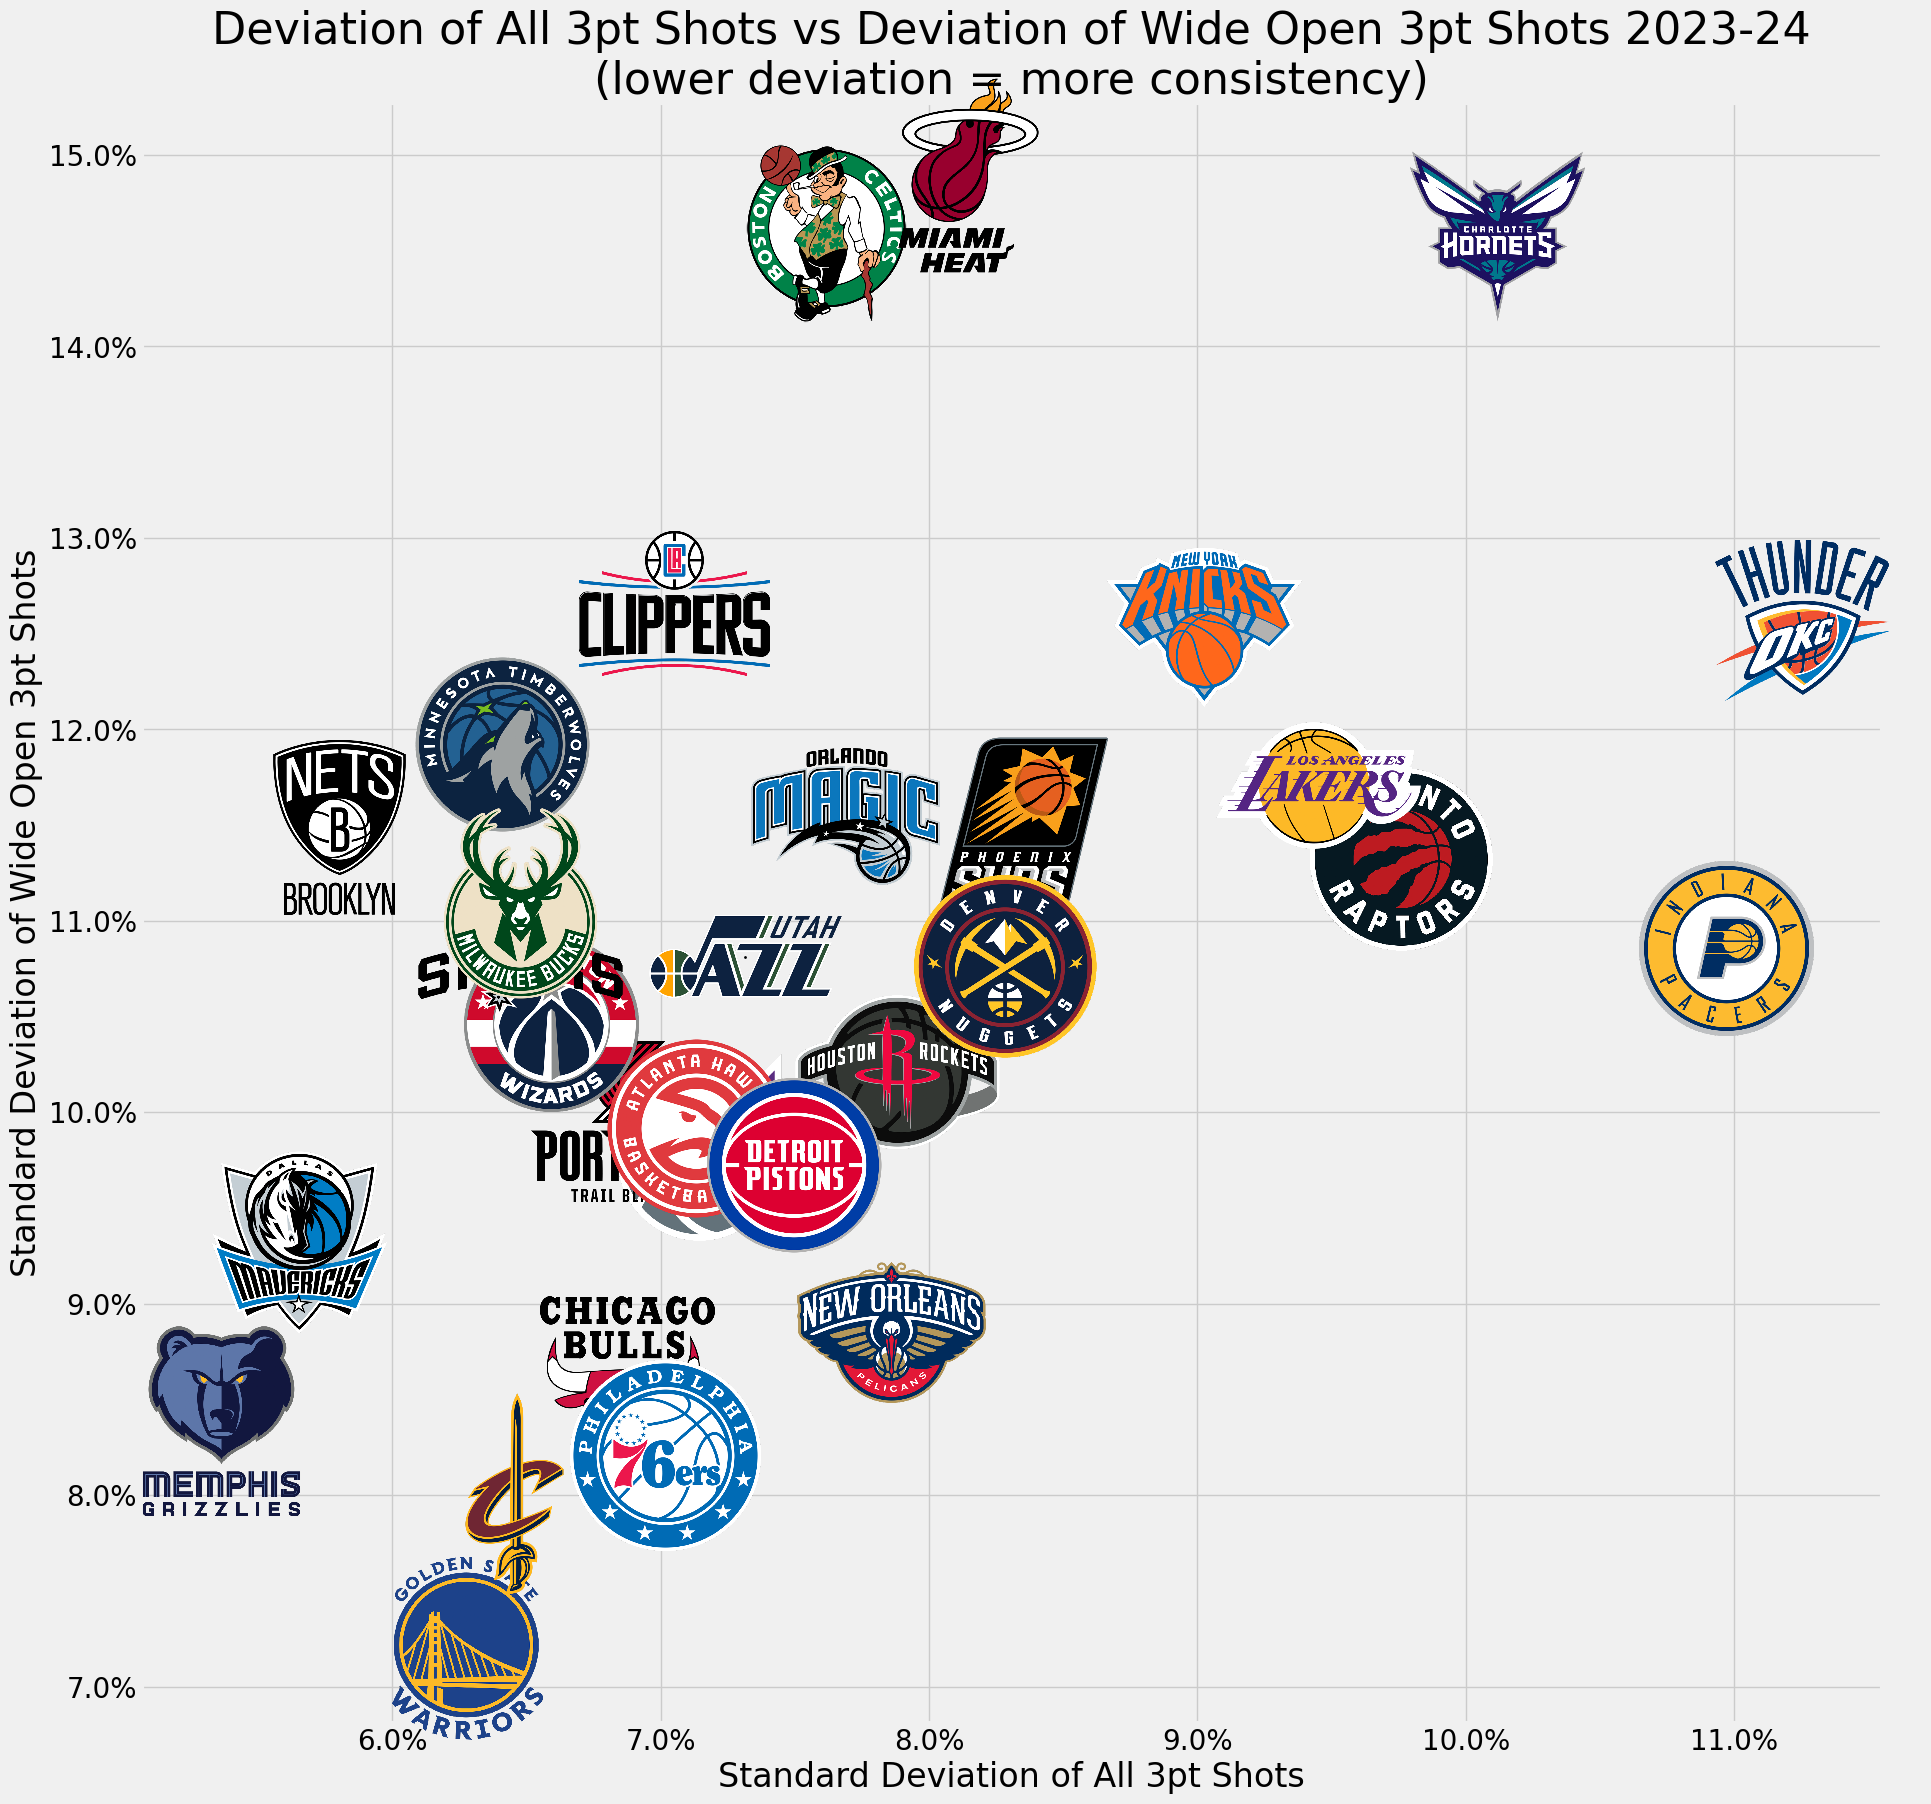

In [56]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.scatter(x=merged_df.FG3_PCT_DEVIATION_ALL, y=merged_df.FG3_PCT_DEVIATION, s=1, edgecolors='black', lw=1)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for i in range(len(merged_df)):
    item = merged_df.iloc[i]
    ab = AnnotationBbox(get_team_img(item.TEAM_ID, zoom=0.2), (item.FG3_PCT_DEVIATION_ALL, item.FG3_PCT_DEVIATION), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel("Standard Deviation of All 3pt Shots", size=24)
ax.set_ylabel("Standard Deviation of Wide Open 3pt Shots", size=24)
ax.tick_params(which='both', labelsize=20)
ax.set_title(f"Deviation of All 3pt Shots vs Deviation of Wide Open 3pt Shots {season}\n(lower deviation = more consistency)", size=32)